<a href="https://colab.research.google.com/github/navneetkrc/Deep-Learning-Experiments-implemented-using-Google-Colab/blob/master/reranker_with_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install flashrank
!pip install transformers
!pip install sentence-transformers
!pip install plotly

In [3]:
import json
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import sentence_transformers
import pandas as pd
from sentence_transformers import CrossEncoder
from tqdm import tqdm
import plotly.express as px

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [5]:

# Function to process a single JSON file
def process_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Extract the search results
    search_results = data.get('searchResults', [])

    # Create a list of dictionaries with the desired columns
    rows = []
    for result in search_results:
        name = result.get("name", "")
        category = result.get("category", "")
        sub_category = result.get("sub_category", "")
        sub_genre = result.get("sub_genre", "")
        productDescription = result.get("productDescription", "")

        all_text = f"{name} {category} {sub_category} {sub_genre} {productDescription}"

        # Use the filename without extension as the query
        query = os.path.splitext(os.path.basename(file_path))[0]

        row = {
            "query": query,
            "name": name,
            "category": category,
            "sub_category": sub_category,
            "sub_genre": sub_genre,
            "productDescription": productDescription,
            "all_text": all_text
        }
        rows.append(row)

    return rows

# Directory containing the JSON files
json_directory = '/content/json_files'

# List to store all rows from all JSON files
all_rows = []

# Process each JSON file in the directory
for filename in os.listdir(json_directory):
    if filename.endswith('.json'):
        file_path = os.path.join(json_directory, filename)
        rows = process_json_file(file_path)
        all_rows.extend(rows)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(all_rows)

# Print the DataFrame
# print(df)

# Optionally, save the DataFrame to a CSV file
# df.to_csv('low_ctr_query_uk.csv', index=False) #aggregate_csv
df.to_csv('aggregate_csv.csv', index=False) #aggregate_csv
df.sample(20)

,query,name,category,sub_category,sub_genre,productDescription,all_text
26,25w charger,15W Super Fast Wireless Charger Pad,Mobile,Mobile Accessories,Smartphones Accessories,Buy the grey 15W Samsung Super Fast Wireless C...,15W Super Fast Wireless Charger Pad Mobile Mob...
75,watch charger,"20,000 mAh Battery Pack (45W Super Fast Chargi...",Mobile,Mobile Accessories,Battery,"20,000 mAh Battery Pack (45W Super Fast Chargi...","20,000 mAh Battery Pack (45W Super Fast Chargi..."
20,camera,Galaxy Z Fold6,Mobile,Smartphones,Galaxy Z,"Meet the Galaxy Z Fold6, the new foldable phon...",Galaxy Z Fold6 Mobile Smartphones Galaxy Z Mee...
27,25w charger,15W Adaptive Fast Charger (USB C without Cable),Mobile,Mobile Accessories,Smartphones Accessories,Buy the black 15W Samsung USB C Super Fast Cha...,15W Adaptive Fast Charger (USB C without Cable...
83,galaxy note 10,Wireless Charger Trio,Mobile,Mobile Accessories,Smartphones Accessories,Buy the black Samsung Wireless Phone Charger T...,Wireless Charger Trio Mobile Mobile Accessorie...
62,printer,Athleisure Band (M/L) for Galaxy Watch 7,Mobile,Mobile Accessories,Wearables Accessories,Buy the Athleisure Smartwatch Band M/L for you...,Athleisure Band (M/L) for Galaxy Watch 7 Mobil...
18,camera,Galaxy S24 Enterprise Edition,Mobile,Smartphones,Galaxy S,Meet the Samsung Galaxy S24 & S24+ Enterprise ...,Galaxy S24 Enterprise Edition Mobile Smartphon...
115,mobiles,Galaxy S24,Mobile,Smartphones,Galaxy S,"Meet the new Samsung Galaxy S24 & S24+, packed...",Galaxy S24 Mobile Smartphones Galaxy S Meet th...
32,25w charger,45W Super Fast Charger 2.0,Mobile,Mobile Accessories,Power,Buy the 45W USB C Port Wall Charger EP-T4511XB...,45W Super Fast Charger 2.0 Mobile Mobile Acces...
99,tablet,Galaxy Tab Active5,Mobile,Tablets,Others,"Meet the 8"" Samsung Galaxy Tab Active5 5G Tabl...",Galaxy Tab Active5 Mobile Tablets Others Meet ...


#Computation of query results relevance scores

In [6]:

from sentence_transformers import CrossEncoder

In [7]:
# Load the CSV file
csv_filename = "aggregate_csv.csv"  # Replace with your actual CSV file name
df = pd.read_csv(csv_filename)
df.tail()

,query,name,category,sub_category,sub_genre,productDescription,all_text
140,keypad,Faux Leather Case / Kindsuit Case for Z Flip6,Mobile,Mobile Accessories,Cases,Buy the Kindsuit Phone Case for your Samsung G...,Faux Leather Case / Kindsuit Case for Z Flip6 ...
141,keypad,Anti-reflecting Screen Protector for Z Fold6,Mobile,Mobile Accessories,Screen Protectors,Buy the Anti Reflecting Film for your Galaxy Z...,Anti-reflecting Screen Protector for Z Fold6 M...
142,keypad,Clear Grip Case for Z Fold6,Mobile,Mobile Accessories,Cases,Buy the Clear Grip Phone Case for your Galaxy ...,Clear Grip Case for Z Fold6 Mobile Mobile Acce...
143,keypad,Clear Case with Ring for Z Flip6,Mobile,Mobile Accessories,Cases,Buy the Clear Phone Case with Ring for your Ga...,Clear Case with Ring for Z Flip6 Mobile Mobile...
144,keypad,Silicone Grip Case with Stand for Z Fold6,Mobile,Mobile Accessories,Cases,Buy the Silicone Case with a built-in stand fo...,Silicone Grip Case with Stand for Z Fold6 Mobi...


In [ ]:


# # # Load the CSV file
# # csv_filename = "aggregate_csv.csv"  # Replace with your actual CSV file name
# # df = pd.read_csv(csv_filename)

# # Load a pre-trained cross-encoder model from Sentence Transformers
# model_name = "cross-encoder/ms-marco-MiniLM-L-12-v2"
# model = CrossEncoder(model_name)

# # Create pairs of query and all_text from the CSV
# pairs = list(zip(df['query'], df['all_text']))

# # Compute the relevance scores using the cross-encoder model
# scores = model.predict(pairs)

# # Add the scores as a new column to the dataframe
# df['scores'] = scores

# # Save the updated dataframe back to the CSV file
# df.to_csv(csv_filename, index=False)

# print(f"Scores appended to '{csv_filename}' successfully!")


In [8]:
%%capture
# import pandas as pd
# from sentence_transformers import CrossEncoder
# from tqdm import tqdm

# Load the CSV file
csv_filename = "aggregate_csv.csv"  # Replace with your actual CSV file name
df = pd.read_csv(csv_filename)

# List of model names to be used with the option to trust remote code and pin a specific revision
models = {
    # "model_jina-reranker-v2-base-multilingual": {"path": "jinaai/jina-reranker-v2-base-multilingual", "trust_remote_code": True, "revision": "main"},
    # "model_jina-reranker-v1-turbo-en": {"path": "jinaai/jina-reranker-v1-turbo-en", "trust_remote_code": True, "revision": "main"},
    # "model_jina-reranker-v1-tiny-en": {"path": "jinaai/jina-reranker-v1-tiny-en", "trust_remote_code": True, "revision": "main"},
    "model_mxbai-rerank-xsmall-v1": {"path": "mixedbread-ai/mxbai-rerank-xsmall-v1", "trust_remote_code": True, "revision": "main"},
    "model_mxbai-rerank-large-v1": {"path": "mixedbread-ai/mxbai-rerank-large-v1", "trust_remote_code": True, "revision": "main"},
    "model_mxbai-rerank-base-v1": {"path": "mixedbread-ai/mxbai-rerank-base-v1", "trust_remote_code": True, "revision": "main"},
    "model_MiniLM": {"path": "cross-encoder/ms-marco-MiniLM-L-12-v2", "trust_remote_code": False}  # This model doesn't require trust_remote_code
}

# Create pairs of query and all_text from the CSV
pairs = list(zip(df['query'], df['all_text']))

# Iterate over each model, compute the scores, and add them to the DataFrame
for model_name, model_info in tqdm(models.items(), desc="Processing models"):
    # Load the CrossEncoder model with or without trust_remote_code and pin the revision
    model = CrossEncoder(model_info["path"], trust_remote_code=model_info["trust_remote_code"], revision=model_info.get("revision", None))

    # Compute the relevance scores using the cross-encoder model
    scores = model.predict(pairs)

    # Create a column name based on the model name
    score_column_name = f"scores_{model_name}"

    # Add the scores as a new column to the dataframe
    df[score_column_name] = scores

    print(f"Scores for {model_name} appended to the DataFrame successfully!")

# Save the updated dataframe back to the CSV file
df.to_csv(csv_filename, index=False)

print(f"Scores for all models appended to '{csv_filename}' successfully!")


In [9]:
%%capture
import pandas as pd
from sentence_transformers import CrossEncoder
from tqdm import tqdm

# Load the CSV file
csv_filename = "aggregate_csv.csv"  # Replace with your actual CSV file name
df = pd.read_csv(csv_filename)

# List of model names to be used with the option to trust remote code and pin a specific revision
models = {
    # "model_jina-reranker-v2-base-multilingual": {"path": "jinaai/jina-reranker-v2-base-multilingual", "trust_remote_code": True, "revision": "main"},
    "model_jina-reranker-v1-turbo-en": {"path": "jinaai/jina-reranker-v1-turbo-en", "trust_remote_code": True, "revision": "main"},
    "model_jina-reranker-v1-tiny-en": {"path": "jinaai/jina-reranker-v1-tiny-en", "trust_remote_code": True, "revision": "main"},
    "model_bge-reranker-base": {"path": "BAAI/bge-reranker-base", "trust_remote_code": True}
    # "model_mxbai-rerank-xsmall-v1": {"path": "mixedbread-ai/mxbai-rerank-xsmall-v1", "trust_remote_code": True, "revision": "main"},
    # "model_mxbai-rerank-large-v1": {"path": "mixedbread-ai/mxbai-rerank-large-v1", "trust_remote_code": True, "revision": "main"},
    # "model_mxbai-rerank-base-v1": {"path": "mixedbread-ai/mxbai-rerank-base-v1", "trust_remote_code": True, "revision": "main"},
    # "model_MiniLM": {"path": "cross-encoder/ms-marco-MiniLM-L-12-v2", "trust_remote_code": False}  # This model doesn't require trust_remote_code
}

# Create pairs of query and all_text from the CSV
pairs = list(zip(df['query'], df['all_text']))

# Iterate over each model, compute the scores, and add them to the DataFrame
for model_name, model_info in tqdm(models.items(), desc="Processing models"):
    # Load the CrossEncoder model with or without trust_remote_code and pin the revision
    model = CrossEncoder(model_info["path"], trust_remote_code=model_info["trust_remote_code"], revision=model_info.get("revision", None))

    # Compute the relevance scores using the cross-encoder model
    scores = model.predict(pairs)

    # Create a column name based on the model name
    score_column_name = f"scores_{model_name}"

    # Add the scores as a new column to the dataframe
    df[score_column_name] = scores

    print(f"Scores for {model_name} appended to the DataFrame successfully!")

# Save the updated dataframe back to the CSV file
df.to_csv(csv_filename, index=False)

print(f"Scores for all models appended to '{csv_filename}' successfully!")


In [10]:
df.tail()

,query,name,category,sub_category,sub_genre,productDescription,all_text,scores_model_mxbai-rerank-xsmall-v1,scores_model_mxbai-rerank-large-v1,scores_model_mxbai-rerank-base-v1,scores_model_MiniLM,scores_model_jina-reranker-v1-turbo-en,scores_model_jina-reranker-v1-tiny-en,scores_model_bge-reranker-base
140,keypad,Faux Leather Case / Kindsuit Case for Z Flip6,Mobile,Mobile Accessories,Cases,Buy the Kindsuit Phone Case for your Samsung G...,Faux Leather Case / Kindsuit Case for Z Flip6 ...,0.121853,0.012105,0.014707,-11.233054,0.034877,0.223958,0.000068
141,keypad,Anti-reflecting Screen Protector for Z Fold6,Mobile,Mobile Accessories,Screen Protectors,Buy the Anti Reflecting Film for your Galaxy Z...,Anti-reflecting Screen Protector for Z Fold6 M...,0.089139,0.014119,0.018364,-11.189518,0.039153,0.242278,0.000089
142,keypad,Clear Grip Case for Z Fold6,Mobile,Mobile Accessories,Cases,Buy the Clear Grip Phone Case for your Galaxy ...,Clear Grip Case for Z Fold6 Mobile Mobile Acce...,0.114426,0.010180,0.016713,-11.203687,0.031750,0.211803,0.000037
143,keypad,Clear Case with Ring for Z Flip6,Mobile,Mobile Accessories,Cases,Buy the Clear Phone Case with Ring for your Ga...,Clear Case with Ring for Z Flip6 Mobile Mobile...,0.110881,0.013645,0.015624,-11.218765,0.035061,0.213159,0.000037
144,keypad,Silicone Grip Case with Stand for Z Fold6,Mobile,Mobile Accessories,Cases,Buy the Silicone Case with a built-in stand fo...,Silicone Grip Case with Stand for Z Fold6 Mobi...,0.069479,0.013555,0.016381,-11.229386,0.039948,0.214691,0.000045


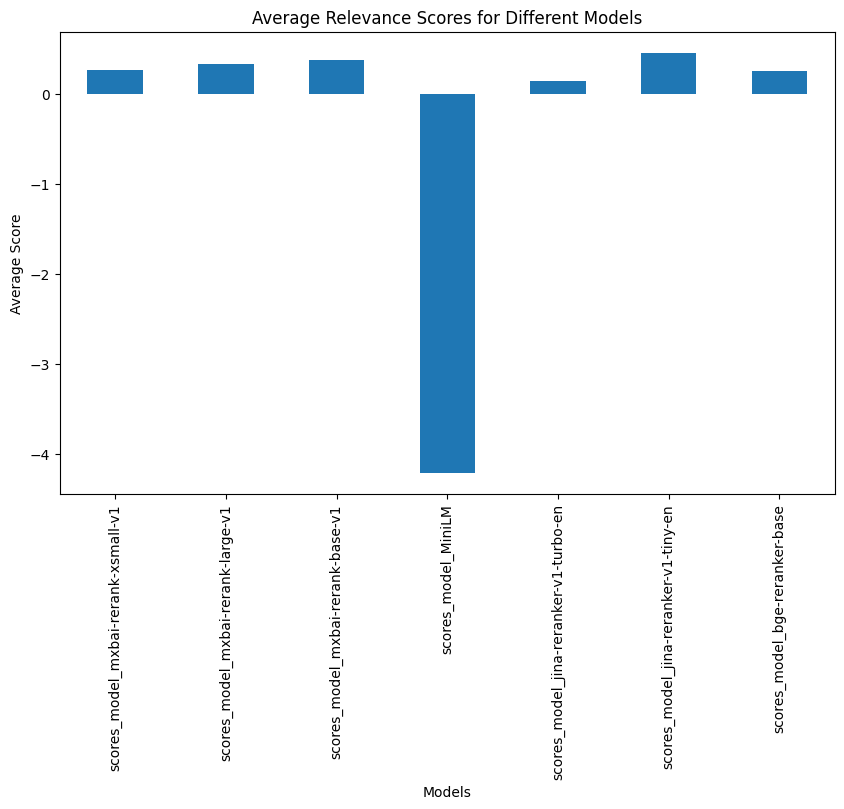

Average scores for each model:
scores_model_mxbai-rerank-xsmall-v1       0.262703
scores_model_mxbai-rerank-large-v1        0.335574
scores_model_mxbai-rerank-base-v1         0.372100
scores_model_MiniLM                      -4.210862
scores_model_jina-reranker-v1-turbo-en    0.137987
scores_model_jina-reranker-v1-tiny-en     0.459359
scores_model_bge-reranker-base            0.257365
dtype: float64


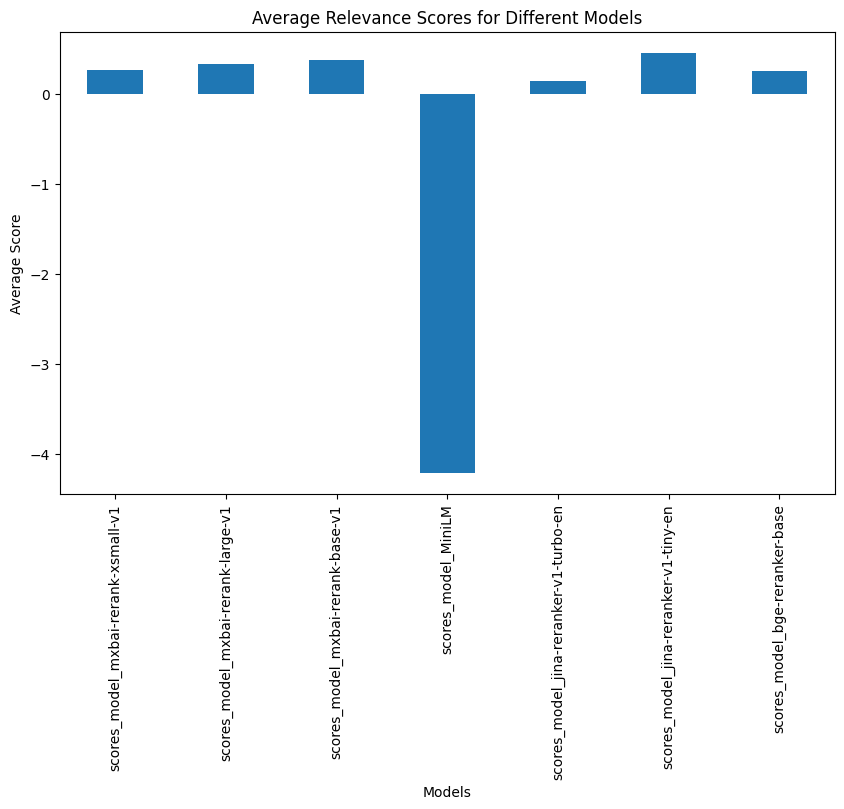

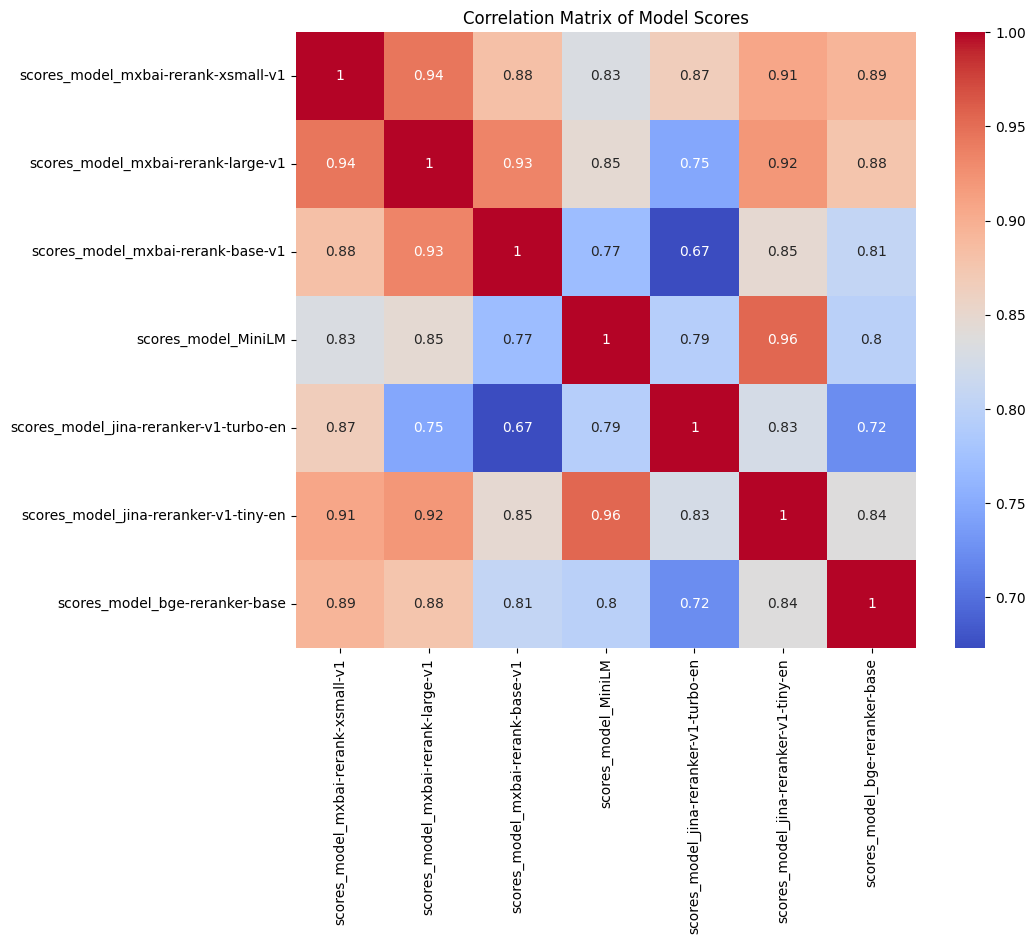

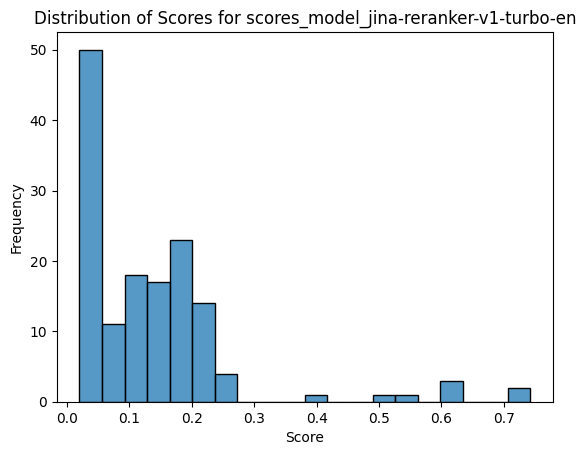

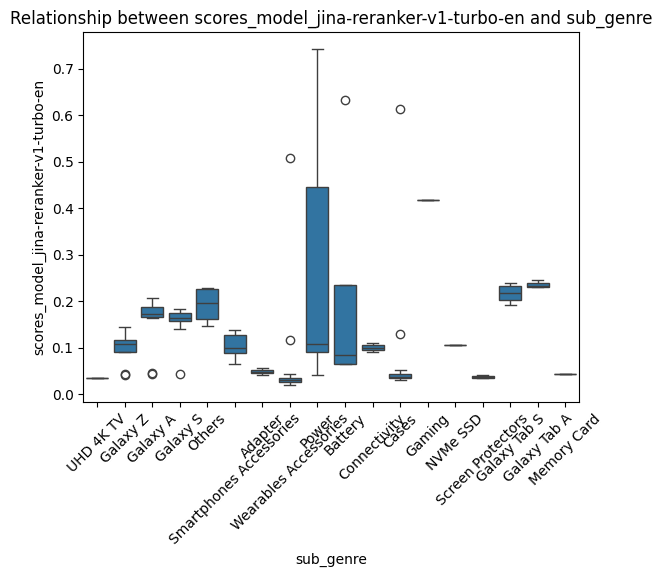

In [13]:
# prompt: do some analytics related to above csv file
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  # Import Matplotlib for basic plot customizations

# Load the CSV file
df = pd.read_csv("aggregate_csv.csv")

# Calculate the average score for each model
model_scores = df.filter(regex='^scores_').mean()

# Create a bar plot of the average scores
model_scores.plot(kind='bar', figsize=(10, 6))
plt.title("Average Relevance Scores for Different Models")  # Use plt from Matplotlib
plt.xlabel("Models")                                     # Use plt from Matplotlib
plt.ylabel("Average Score")                                # Use plt from Matplotlib
plt.show()

# ... (rest of your code)


# Print the average scores
print("Average scores for each model:")
print(model_scores)

# Create a bar plot of the average scores
model_scores.plot(kind='bar', figsize=(10, 6))
plt.title("Average Relevance Scores for Different Models")
plt.xlabel("Models")
plt.ylabel("Average Score")
plt.show()

# Calculate the correlation between different model scores
correlation_matrix = df.filter(regex='^scores_').corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Model Scores")
plt.show()

# Analyze the distribution of scores for a specific model
model_name = "scores_model_jina-reranker-v1-turbo-en"  # Replace with the desired model name
sns.histplot(df[model_name], bins=20)
plt.title(f"Distribution of Scores for {model_name}")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Analyze the relationship between scores and other variables
# For example, analyze the relationship between scores and sub_genre
sns.boxplot(x="sub_genre", y=model_name, data=df)
plt.title(f"Relationship between {model_name} and sub_genre")
# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.show()


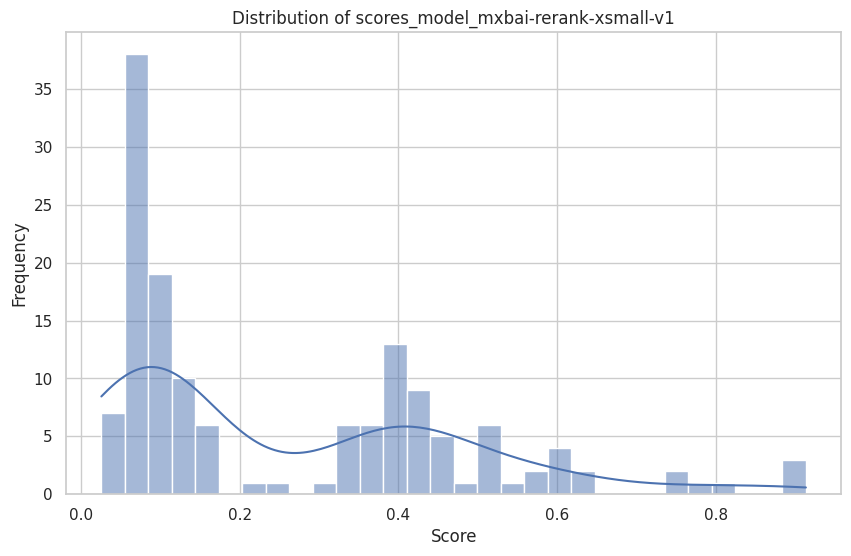

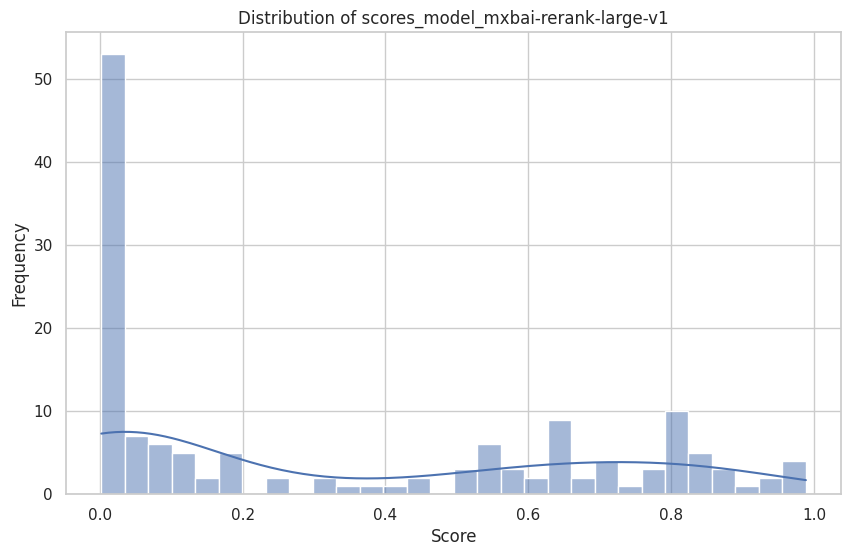

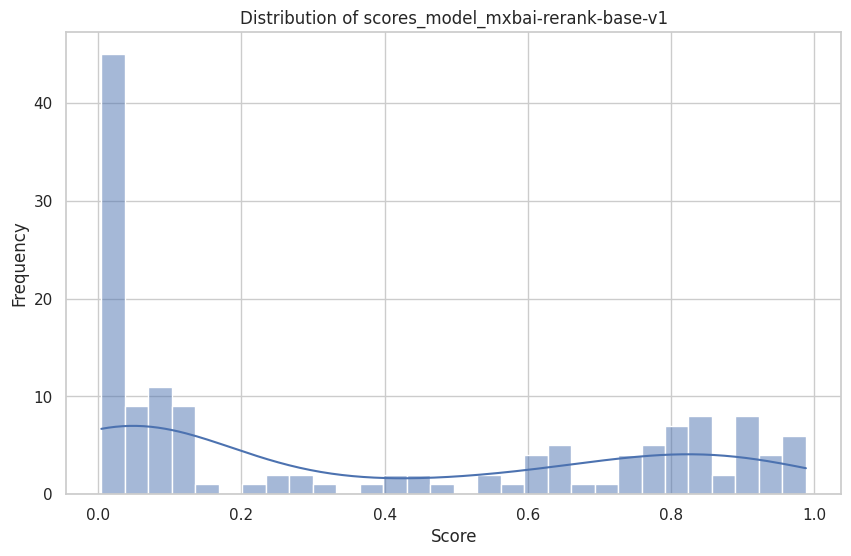

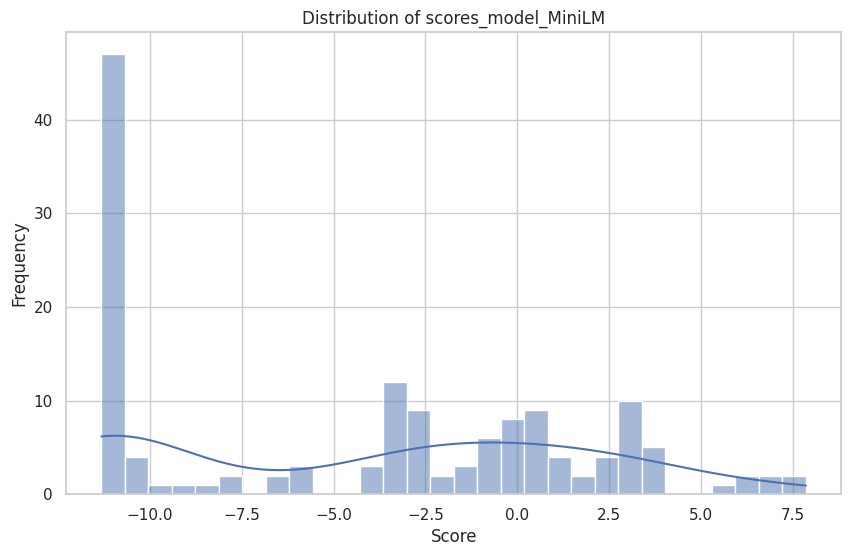

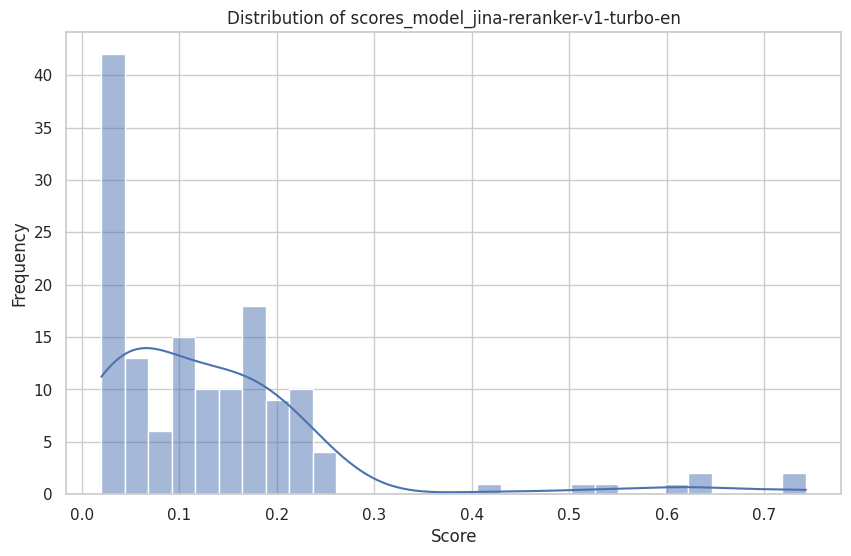

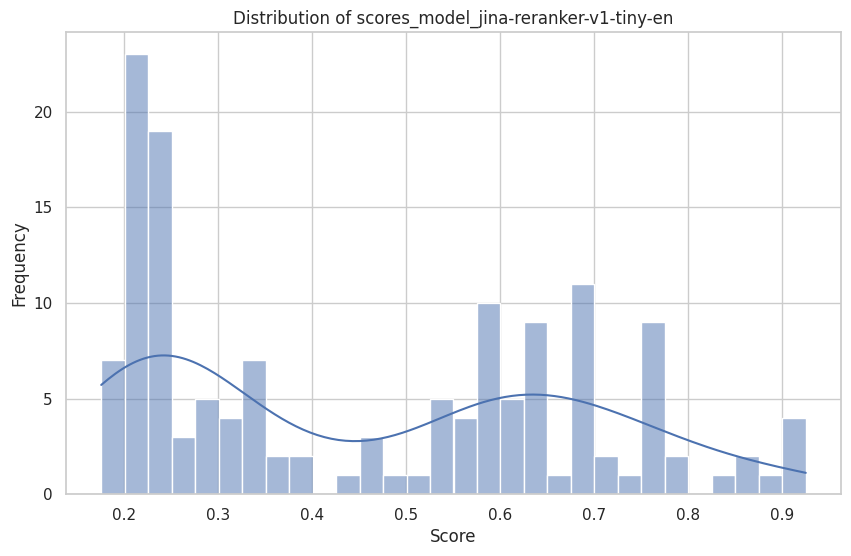

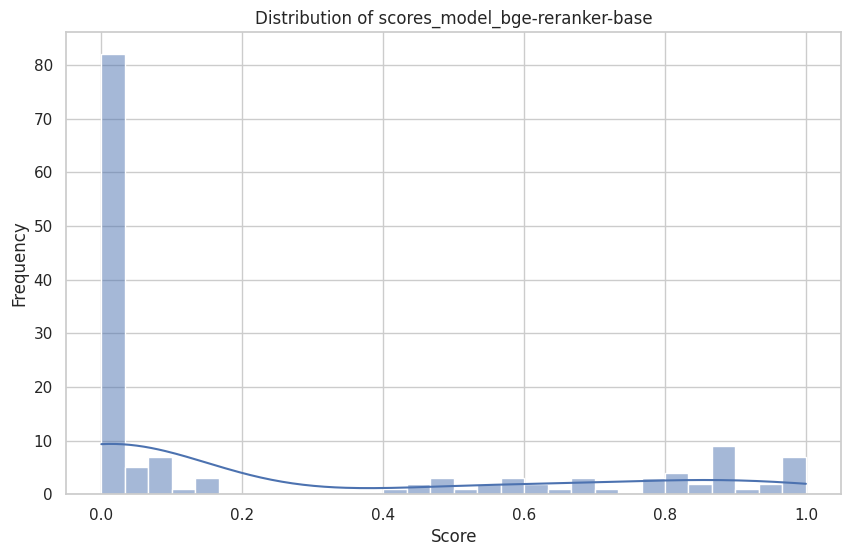

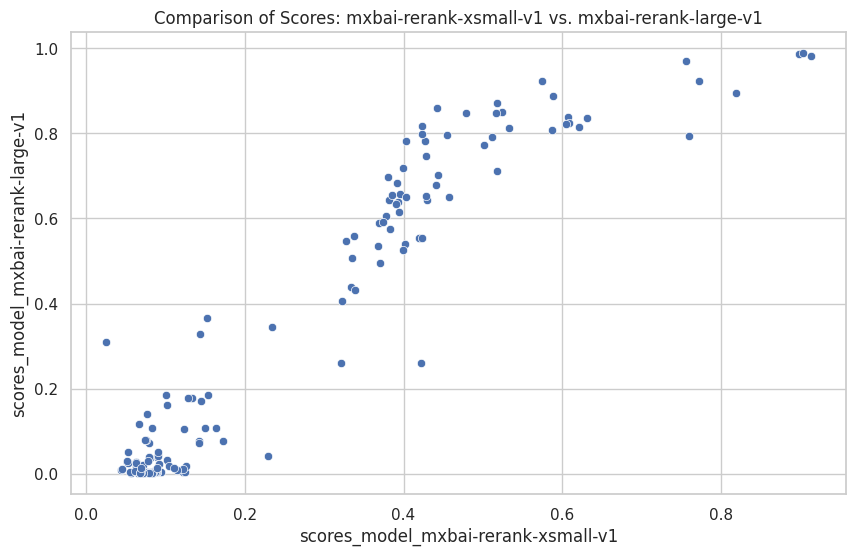

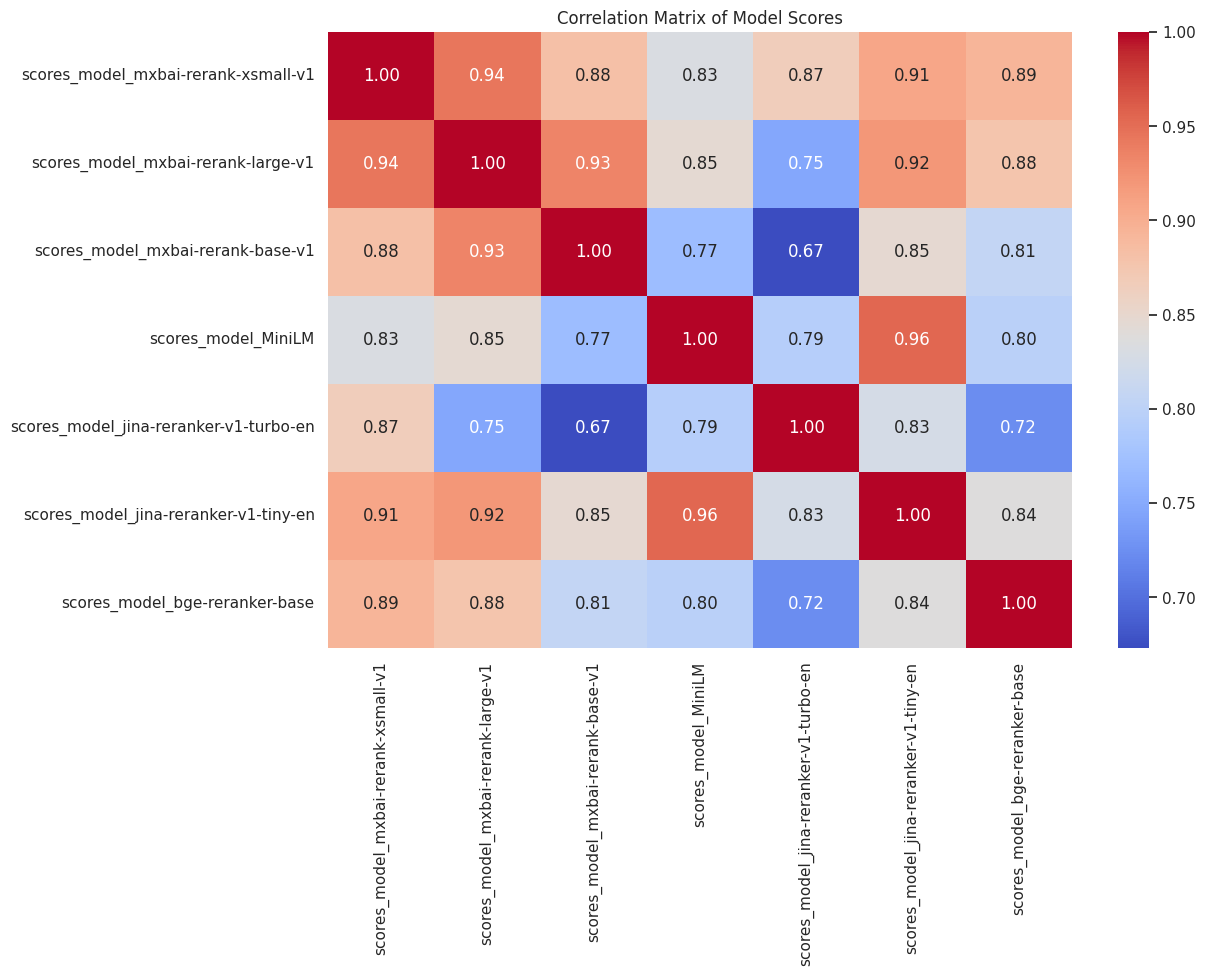

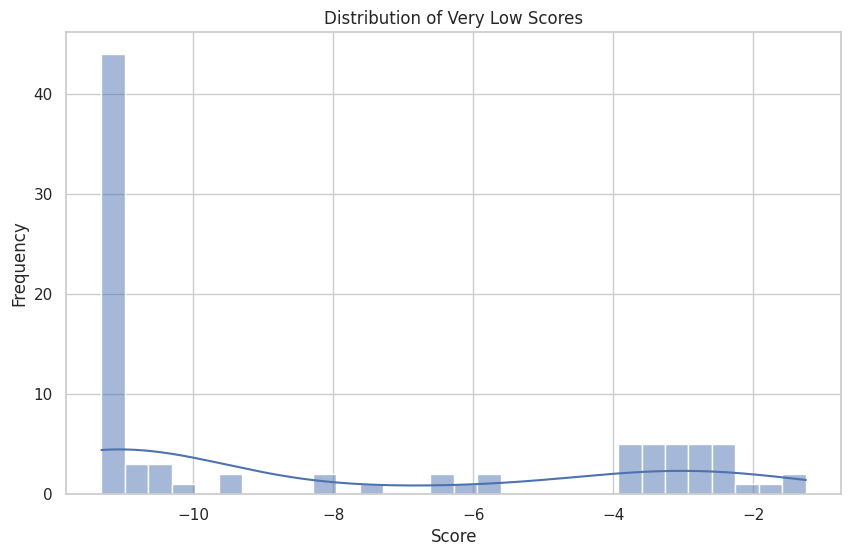

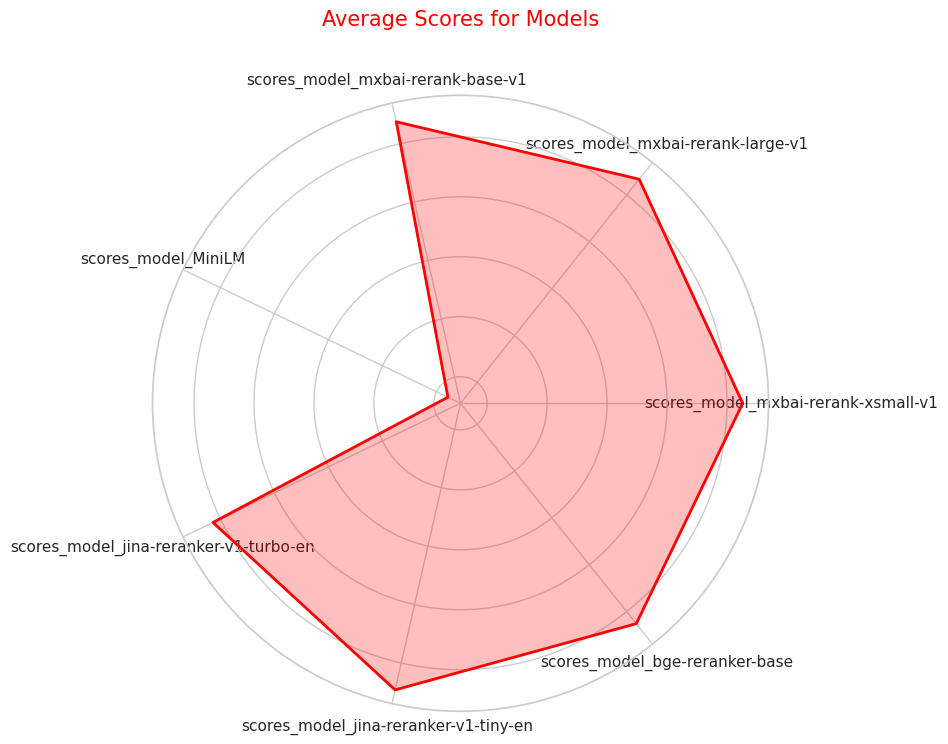

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataframe
df = pd.read_csv("aggregate_csv.csv")

# Set style for seaborn
sns.set(style="whitegrid")

# 1. Histogram of scores for each model
models = [col for col in df.columns if col.startswith('scores_')]
for model in models:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[model], kde=True, bins=30)
    plt.title(f'Distribution of {model}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

# 2. Scatter plot comparing scores from two models
plt.figure(figsize=(10, 6))
sns.scatterplot(x='scores_model_mxbai-rerank-xsmall-v1', y='scores_model_mxbai-rerank-large-v1', data=df)
plt.title('Comparison of Scores: mxbai-rerank-xsmall-v1 vs. mxbai-rerank-large-v1')
plt.xlabel('scores_model_mxbai-rerank-xsmall-v1')
plt.ylabel('scores_model_mxbai-rerank-large-v1')
plt.show()

# 3. Heatmap of score correlations
plt.figure(figsize=(12, 8))
correlation_matrix = df[models].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Model Scores')
plt.show()

# 4. Histogram of very low scores
low_scores_threshold = -1  # Define what you consider a low score
low_scores_df = df[df[models].min(axis=1) < low_scores_threshold]
plt.figure(figsize=(10, 6))
sns.histplot(low_scores_df[models].min(axis=1), kde=True, bins=30)
plt.title('Distribution of Very Low Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# 5. Performance radar chart
from math import pi

def radar_chart(data, title):
    labels = list(data.index)
    values = data.values
    num_vars = len(labels)

    # Complete the loop
    values = list(values) + [values[0]]
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)] + [0]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='red', alpha=0.25)
    ax.plot(angles, values, color='red', linewidth=2)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    plt.title(title, size=15, color='red', y=1.1)
    plt.show()

# Radar chart for model performance
radar_chart(df[models].mean(), 'Average Scores for Models')




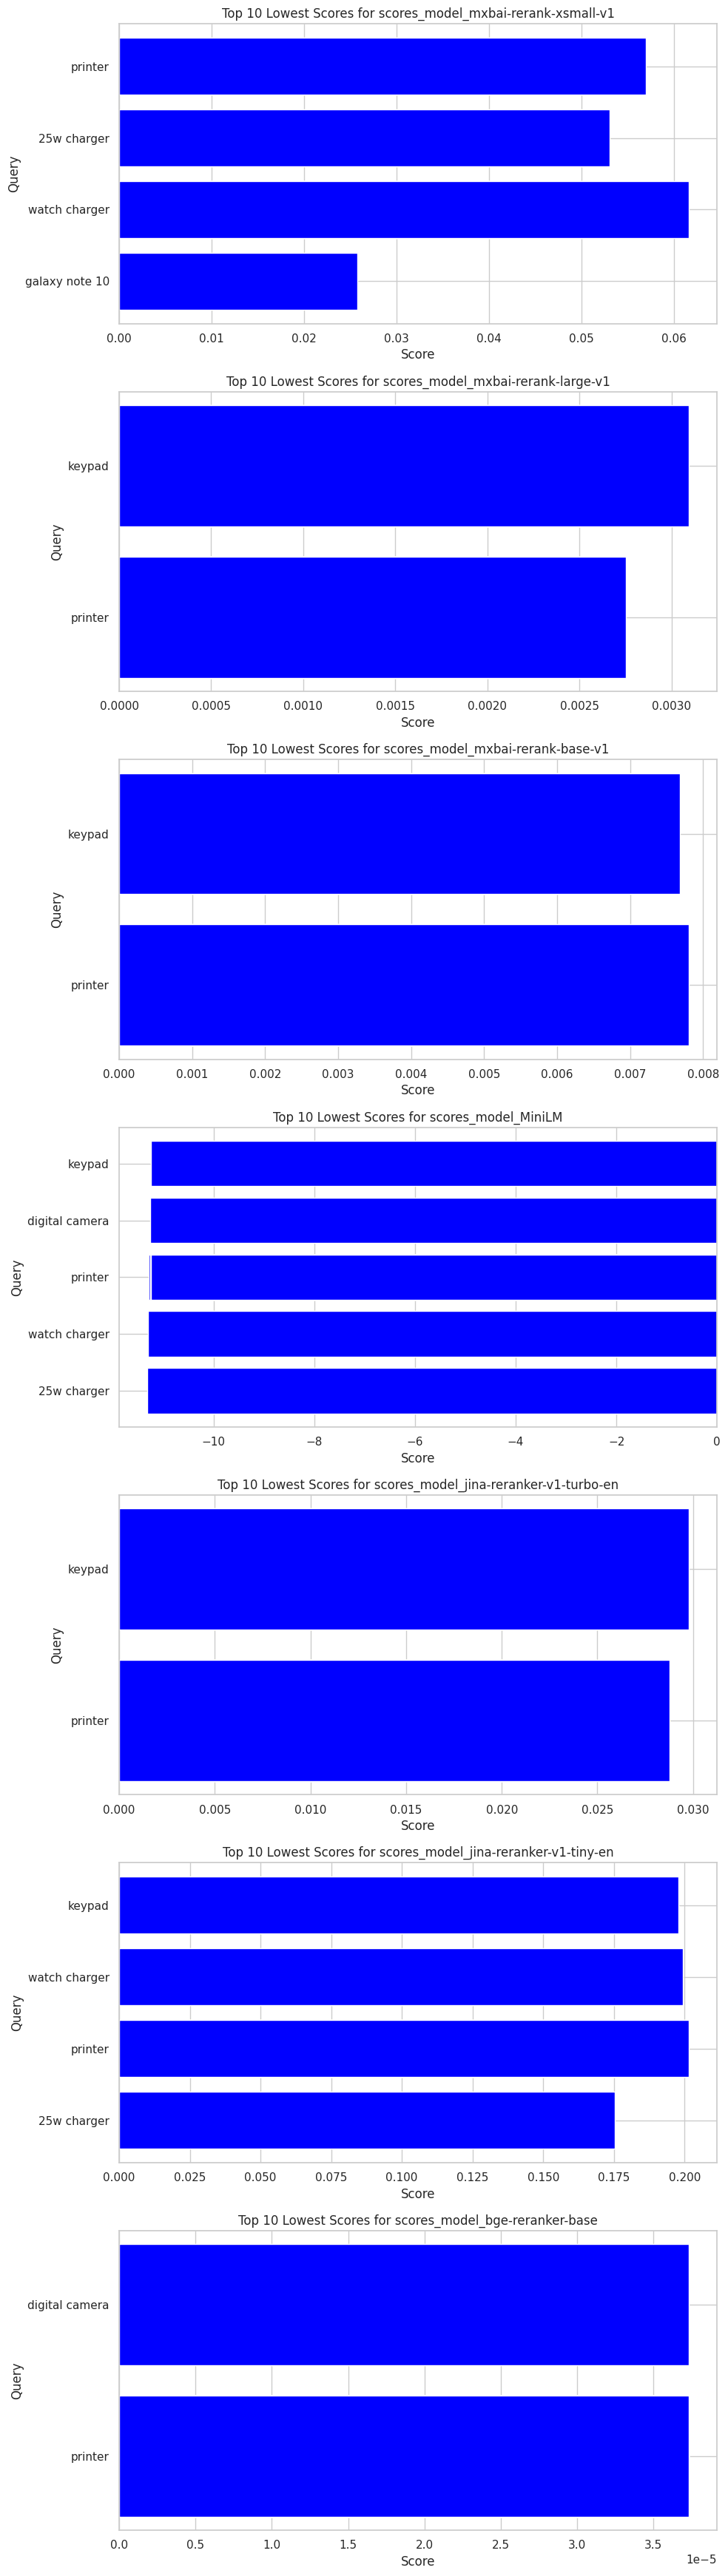

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
# csv_filename = "aggregate_csv.csv"  # Replace with your actual CSV file name
# df = pd.read_csv(csv_filename)

# List of model names to visualize
model_columns = [
    "scores_model_mxbai-rerank-xsmall-v1",
    "scores_model_mxbai-rerank-large-v1",
    "scores_model_mxbai-rerank-base-v1",
    "scores_model_MiniLM",
    "scores_model_jina-reranker-v1-turbo-en",
    "scores_model_jina-reranker-v1-tiny-en",
    "scores_model_bge-reranker-base"
]

# Create a figure and axis for the plots
fig, axes = plt.subplots(nrows=len(model_columns), ncols=1, figsize=(10, len(model_columns) * 5))

# If there's only one model, `axes` will not be a list, so make it iterable
if len(model_columns) == 1:
    axes = [axes]

# Loop through each model column
for model_name, ax in zip(model_columns, axes):
    # Sort the DataFrame by the model scores and get the top 10 lowest scores
    top_10_lowest = df.nsmallest(10, model_name)

    # Plot the results
    ax.barh(top_10_lowest['query'], top_10_lowest[model_name], color='blue')
    ax.set_title(f'Top 10 Lowest Scores for {model_name}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Query')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


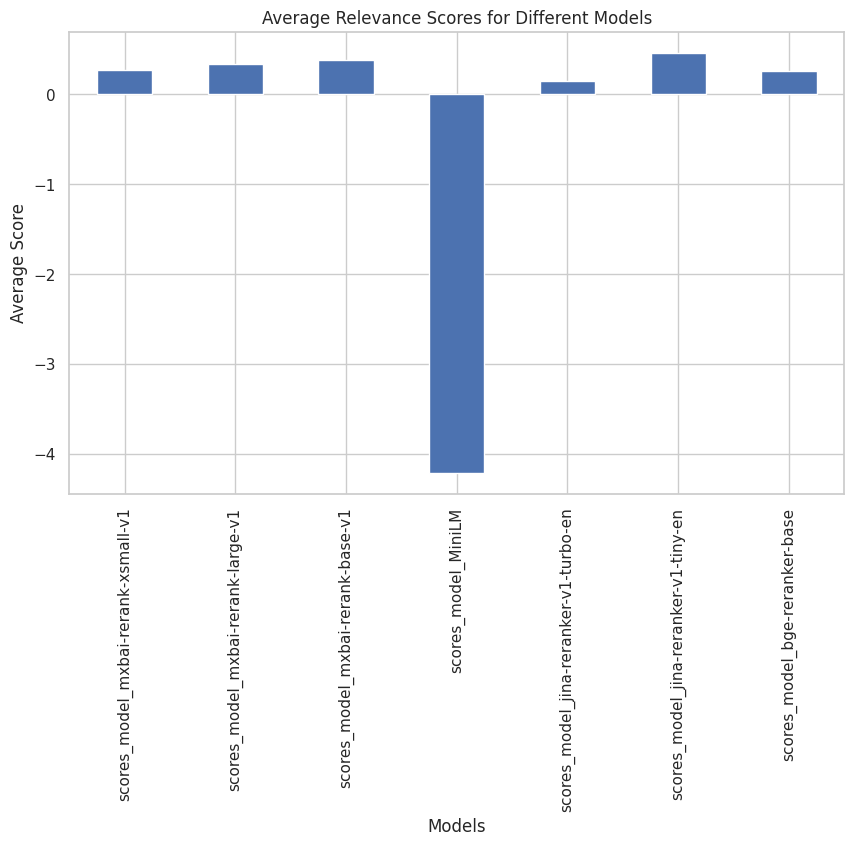

Average scores for each model:
scores_model_mxbai-rerank-xsmall-v1       0.262703
scores_model_mxbai-rerank-large-v1        0.335574
scores_model_mxbai-rerank-base-v1         0.372100
scores_model_MiniLM                      -4.210862
scores_model_jina-reranker-v1-turbo-en    0.137987
scores_model_jina-reranker-v1-tiny-en     0.459359
scores_model_bge-reranker-base            0.257365
dtype: float64


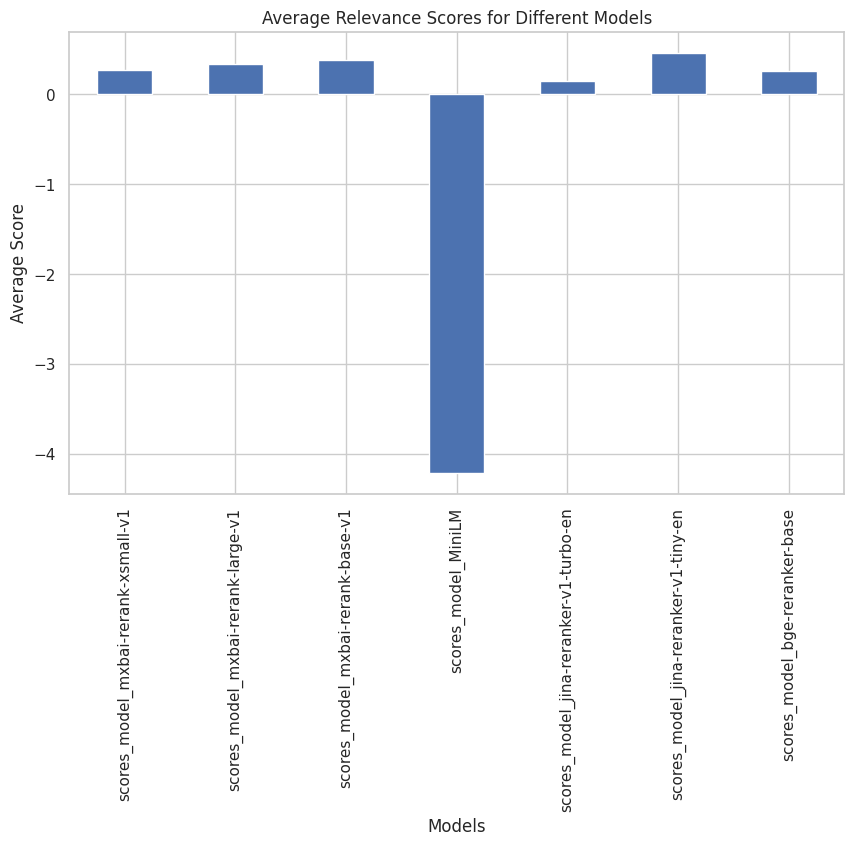

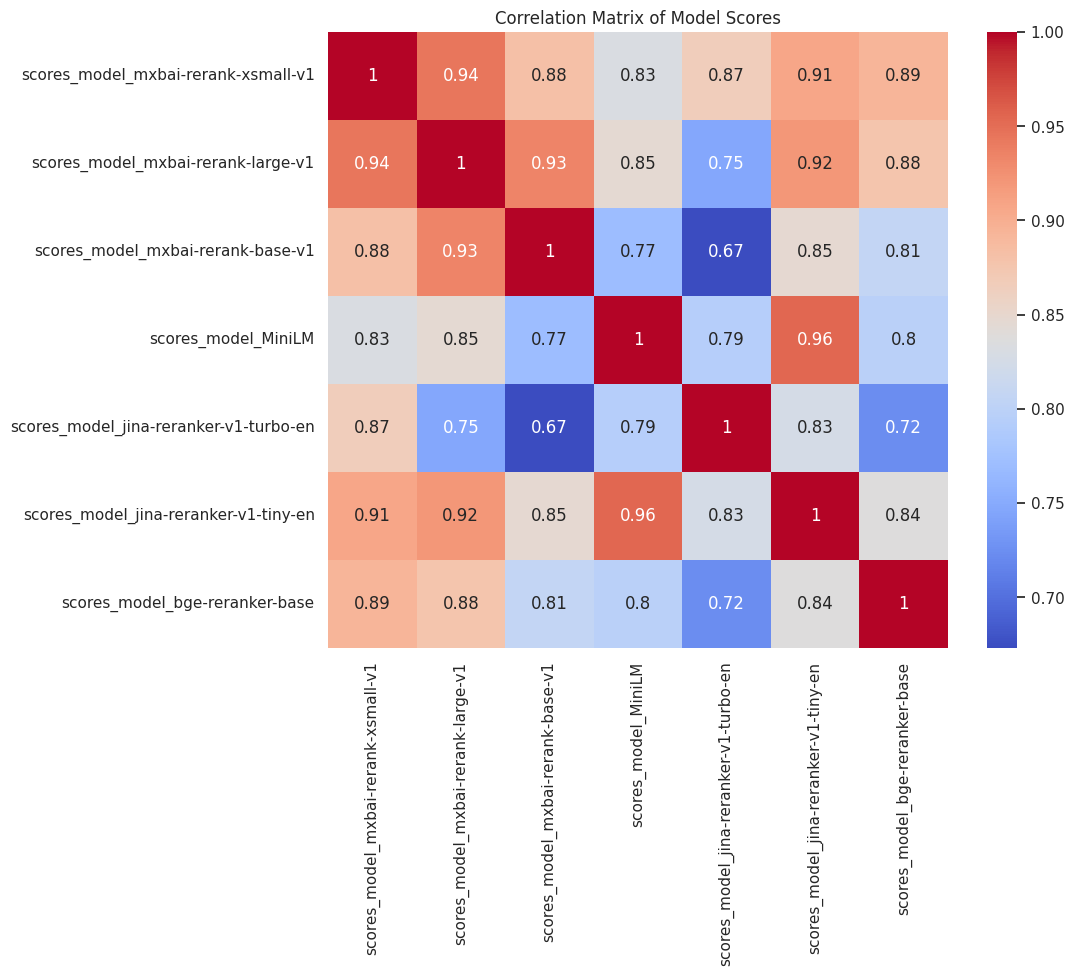

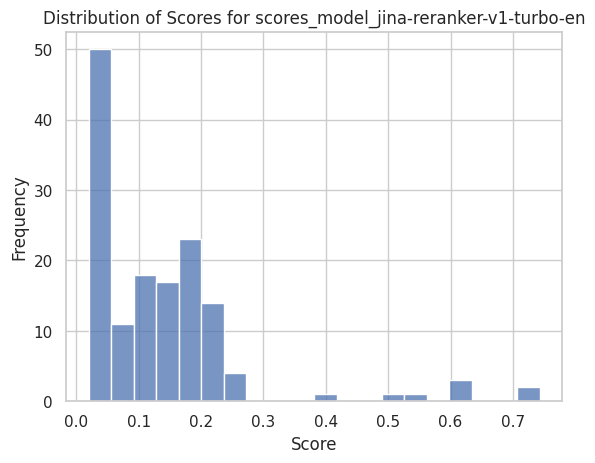

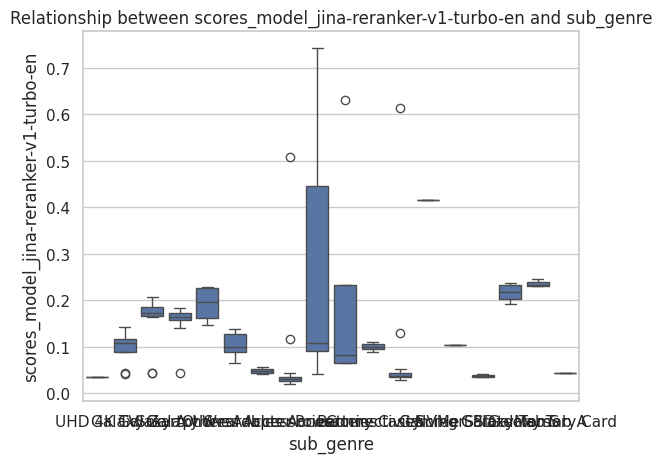

In [18]:
# prompt: do some analytics related to above csv file
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  # Import Matplotlib for basic plot customizations

# ... (rest of your code)

# Create a bar plot of the average scores
model_scores.plot(kind='bar', figsize=(10, 6))
plt.title("Average Relevance Scores for Different Models")  # Use plt from Matplotlib
plt.xlabel("Models")                                     # Use plt from Matplotlib
plt.ylabel("Average Score")                                # Use plt from Matplotlib
plt.show()

# ... (rest of your code)
# Load the CSV file
# df = pd.read_csv("aggregate_final_csv.csv")

# Calculate the average score for each model
model_scores = df.filter(regex='^scores_').mean()

# Print the average scores
print("Average scores for each model:")
print(model_scores)

# Create a bar plot of the average scores
model_scores.plot(kind='bar', figsize=(10, 6))
plt.title("Average Relevance Scores for Different Models")
plt.xlabel("Models")
plt.ylabel("Average Score")
plt.show()

# Calculate the correlation between different model scores
correlation_matrix = df.filter(regex='^scores_').corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Model Scores")
plt.show()

# Analyze the distribution of scores for a specific model
model_name = "scores_model_jina-reranker-v1-turbo-en"  # Replace with the desired model name
sns.histplot(df[model_name], bins=20)
plt.title(f"Distribution of Scores for {model_name}")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Analyze the relationship between scores and other variables
# For example, analyze the relationship between scores and sub_genre
sns.boxplot(x="sub_genre", y=model_name, data=df)
plt.title(f"Relationship between {model_name} and sub_genre")
plt.show()


Average scores for each model:
scores_model_mxbai-rerank-xsmall-v1       0.262703
scores_model_mxbai-rerank-large-v1        0.335574
scores_model_mxbai-rerank-base-v1         0.372100
scores_model_MiniLM                      -4.210862
scores_model_jina-reranker-v1-turbo-en    0.137987
scores_model_jina-reranker-v1-tiny-en     0.459359
scores_model_bge-reranker-base            0.257365
dtype: float64


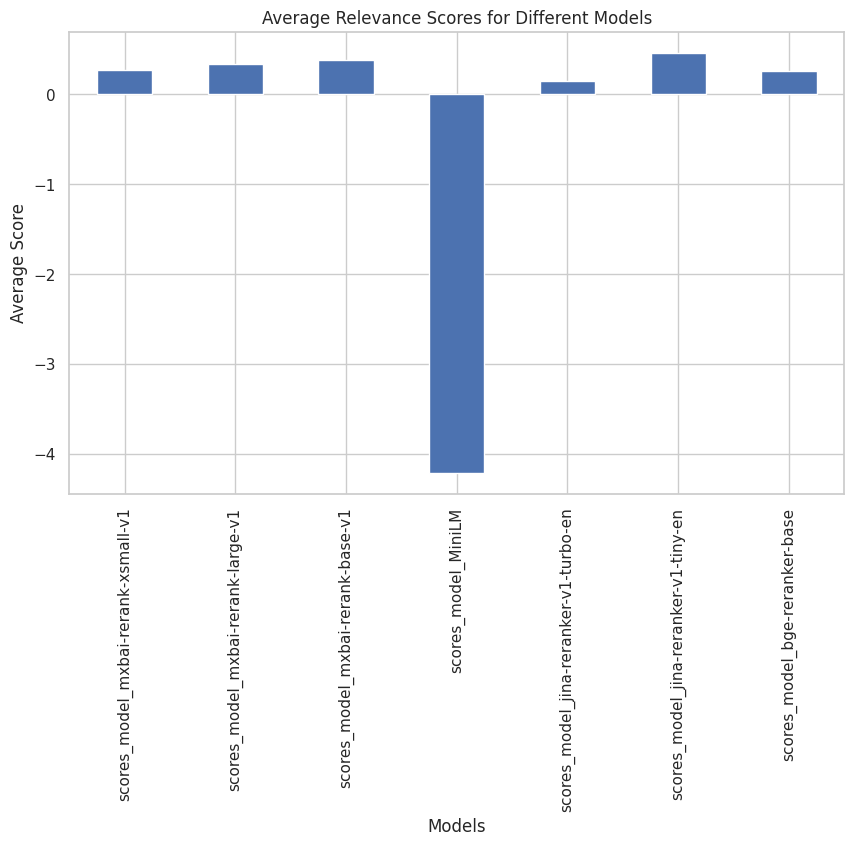

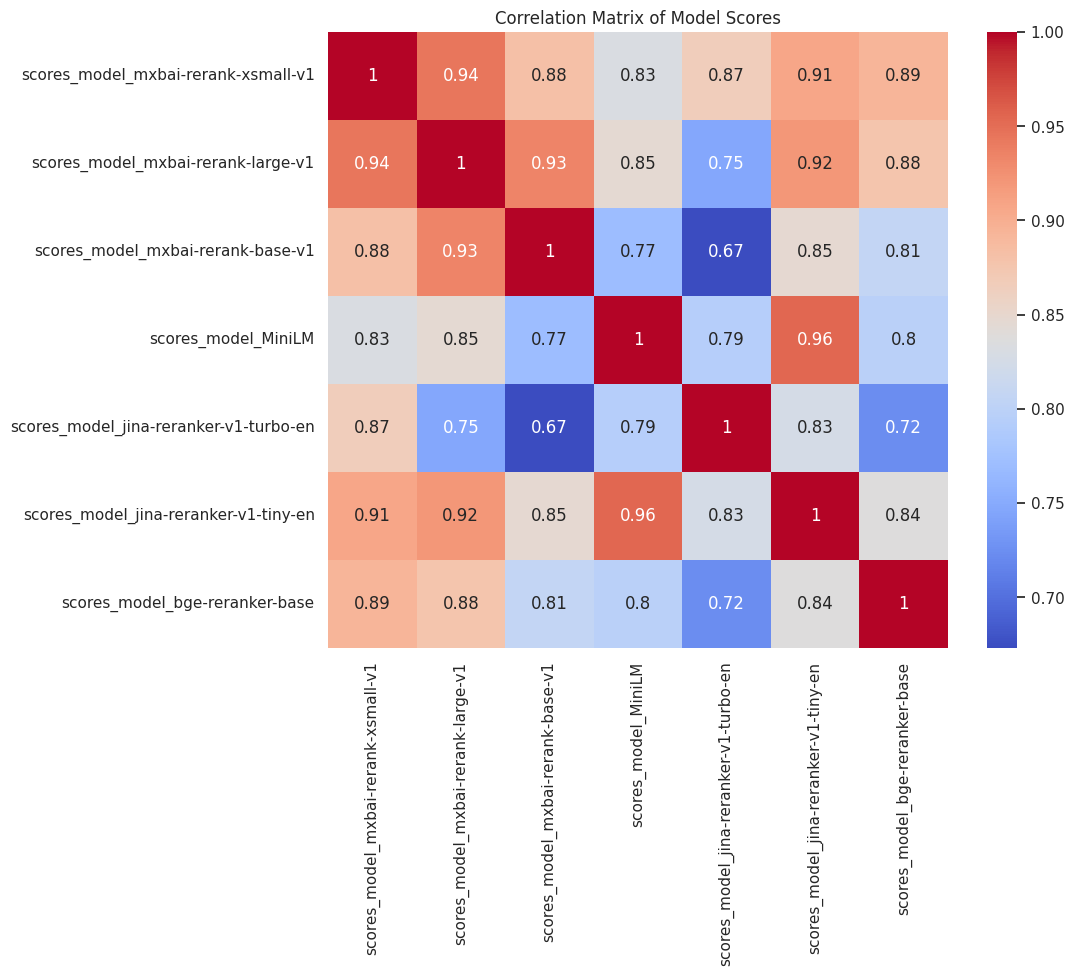

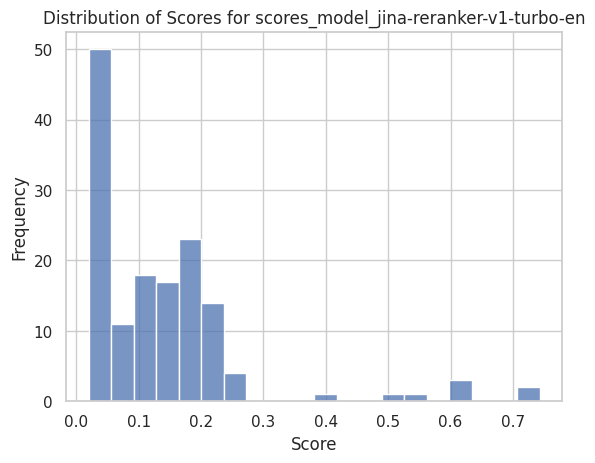

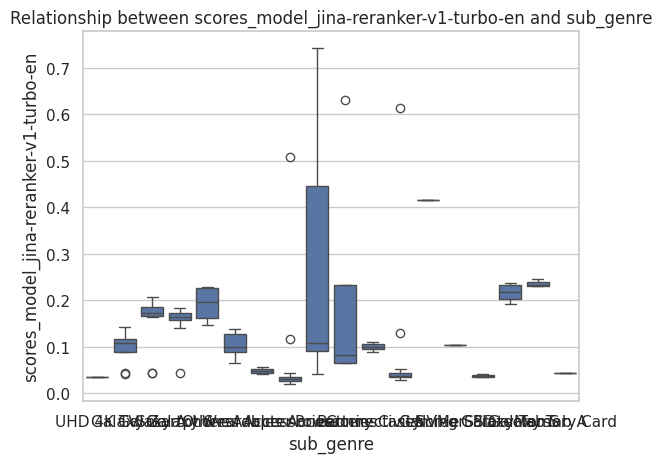

In [20]:
# prompt: how can we get more valuable insights for score comparison between different models
# objective is to find relevancy with the query and all_text columns

# Load the CSV file
# df = pd.read_csv("aggregate_final_csv.csv")

# Calculate the average score for each model
model_scores = df.filter(regex='^scores_').mean()

# Print the average scores
print("Average scores for each model:")
print(model_scores)

# Create a bar plot of the average scores
model_scores.plot(kind='bar', figsize=(10, 6))
plt.title("Average Relevance Scores for Different Models")
plt.xlabel("Models")
plt.ylabel("Average Score")
plt.show()

# Calculate the correlation between different model scores
correlation_matrix = df.filter(regex='^scores_').corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Model Scores")
plt.show()

# Analyze the distribution of scores for a specific model
model_name = "scores_model_jina-reranker-v1-turbo-en"  # Replace with the desired model name
sns.histplot(df[model_name], bins=20)
plt.title(f"Distribution of Scores for {model_name}")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Analyze the relationship between scores and other variables
# For example, analyze the relationship between scores and sub_genre
sns.boxplot(x="sub_genre", y=model_name, data=df)
plt.title(f"Relationship between {model_name} and sub_genre")
plt.show()


In [23]:
import pandas as pd
import plotly.express as px

# Load the CSV file
# csv_filename = "aggregate_final_csv.csv"  # Replace with your actual CSV file name
# df = pd.read_csv(csv_filename)

# List of model names to visualize
model_columns = [
    "scores_model_mxbai-rerank-xsmall-v1",
    "scores_model_mxbai-rerank-large-v1",
    "scores_model_mxbai-rerank-base-v1",
    "scores_model_MiniLM",
    "scores_model_jina-reranker-v1-turbo-en",
    "scores_model_jina-reranker-v1-tiny-en",
    "scores_model_bge-reranker-base"
]

# Create an interactive plot for each model
for model_name in model_columns:
    # Sort the DataFrame by the model scores and get the top 10 lowest scores
    top_10_lowest = df.nsmallest(10, model_name)

    # Create the interactive bar plot
    fig = px.bar(
        top_10_lowest,
        y='query',
        x=model_name,
        text=model_name,
        hover_data={'query': True, 'name': True, model_name: True},
        title=f'Top 10 Lowest Scores for {model_name}',
        labels={'query': 'Query', model_name: 'Score'}
    )

    # Update layout for better visualization
    fig.update_layout(
        xaxis_title='Score',
        yaxis_title='Query',
        xaxis=dict(tickangle=-45)
    )

    # Show the plot
    fig.show()


In [24]:
import pandas as pd

# Load the CSV file
# csv_filename = "aggregate_final_csv.csv"  # Replace with your actual CSV file name
# df = pd.read_csv(csv_filename)

# List of model names to process
model_columns = [
    "scores_model_mxbai-rerank-xsmall-v1",
    "scores_model_mxbai-rerank-large-v1",
    "scores_model_mxbai-rerank-base-v1",
    "scores_model_MiniLM",
    "scores_model_jina-reranker-v1-turbo-en",
    "scores_model_jina-reranker-v1-tiny-en",
    "scores_model_bge-reranker-base"
]

# Initialize a list to collect results for each model
results = []

for model_name in model_columns:
    # Find the top 10 rows with the highest scores for the current model
    top_10_highest = df.nlargest(10, model_name)

    # Find the top 10 rows with the lowest scores for the current model
    top_10_lowest = df.nsmallest(10, model_name)

    # Label the results for identification
    top_10_highest['Score_Type'] = 'Top 10 Highest'
    top_10_lowest['Score_Type'] = 'Top 10 Lowest'

    # Append these results to the list
    results.append(top_10_highest)
    results.append(top_10_lowest)

# Concatenate all results into a single DataFrame
combined_df = pd.concat(results)

# Save the combined DataFrame to a new CSV file
aggregate_csv_filename = "top_10_highest_and_lowest_scores_subset.csv"
combined_df.to_csv(aggregate_csv_filename, index=False)

print(f"Subset CSV with top 10 highest and lowest scores for each model saved to '{aggregate_csv_filename}'")


Subset CSV with top 10 highest and lowest scores for each model saved to 'top_10_highest_and_lowest_scores_subset.csv'


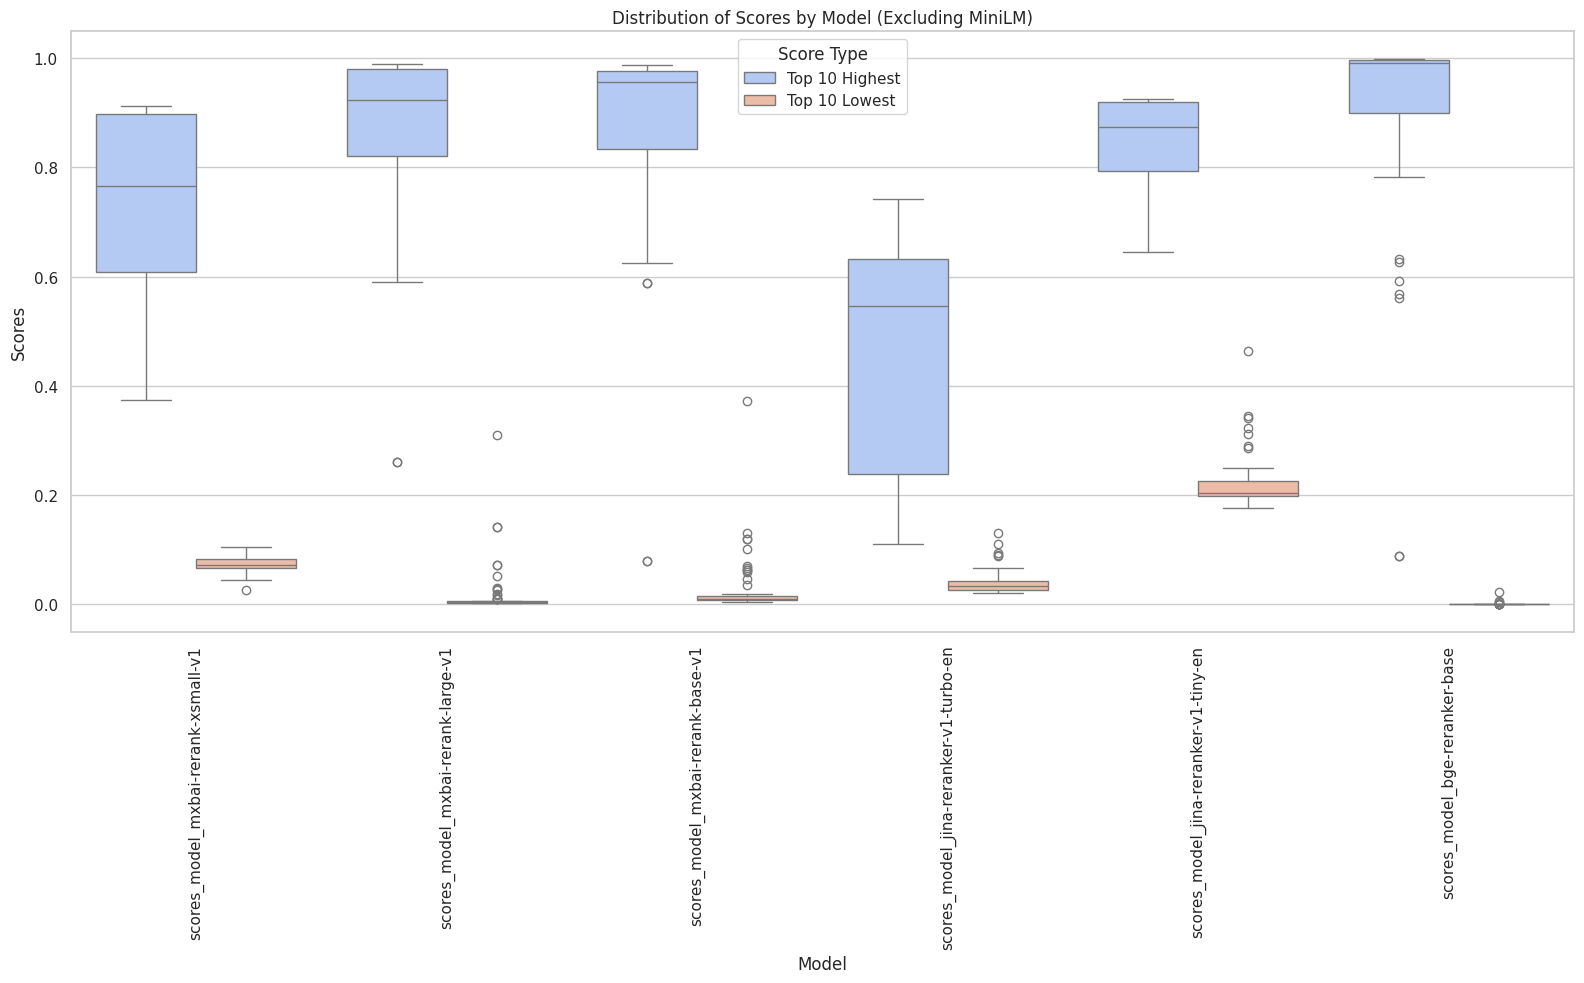

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the combined CSV file
csv_filename = "top_10_highest_and_lowest_scores_subset.csv"  # Replace with your actual CSV file name
df = pd.read_csv(csv_filename)

# Exclude the 'scores_model_MiniLM' column from the DataFrame
df_filtered = df.loc[:, ~df.columns.str.contains('scores_model_MiniLM')]

# Filter only the scores columns and melt the DataFrame
score_columns = [col for col in df_filtered.columns if col.startswith('scores_model')]
df_melted = df_filtered.melt(id_vars=['query', 'name', 'Score_Type'], value_vars=score_columns, var_name='Model', value_name='Score')

plt.figure(figsize=(16, 10))

# Create a box plot
sns.boxplot(data=df_melted, x='Model', y='Score', hue='Score_Type', palette='coolwarm')

# Enhance the plot
plt.xticks(rotation=90)
plt.title('Distribution of Scores by Model (Excluding MiniLM)')
plt.xlabel('Model')
plt.ylabel('Scores')
plt.legend(title='Score Type')
plt.tight_layout()

# Save the box plot
plt.savefig("box_plot_scores_excluding_MiniLM.png")
plt.show()


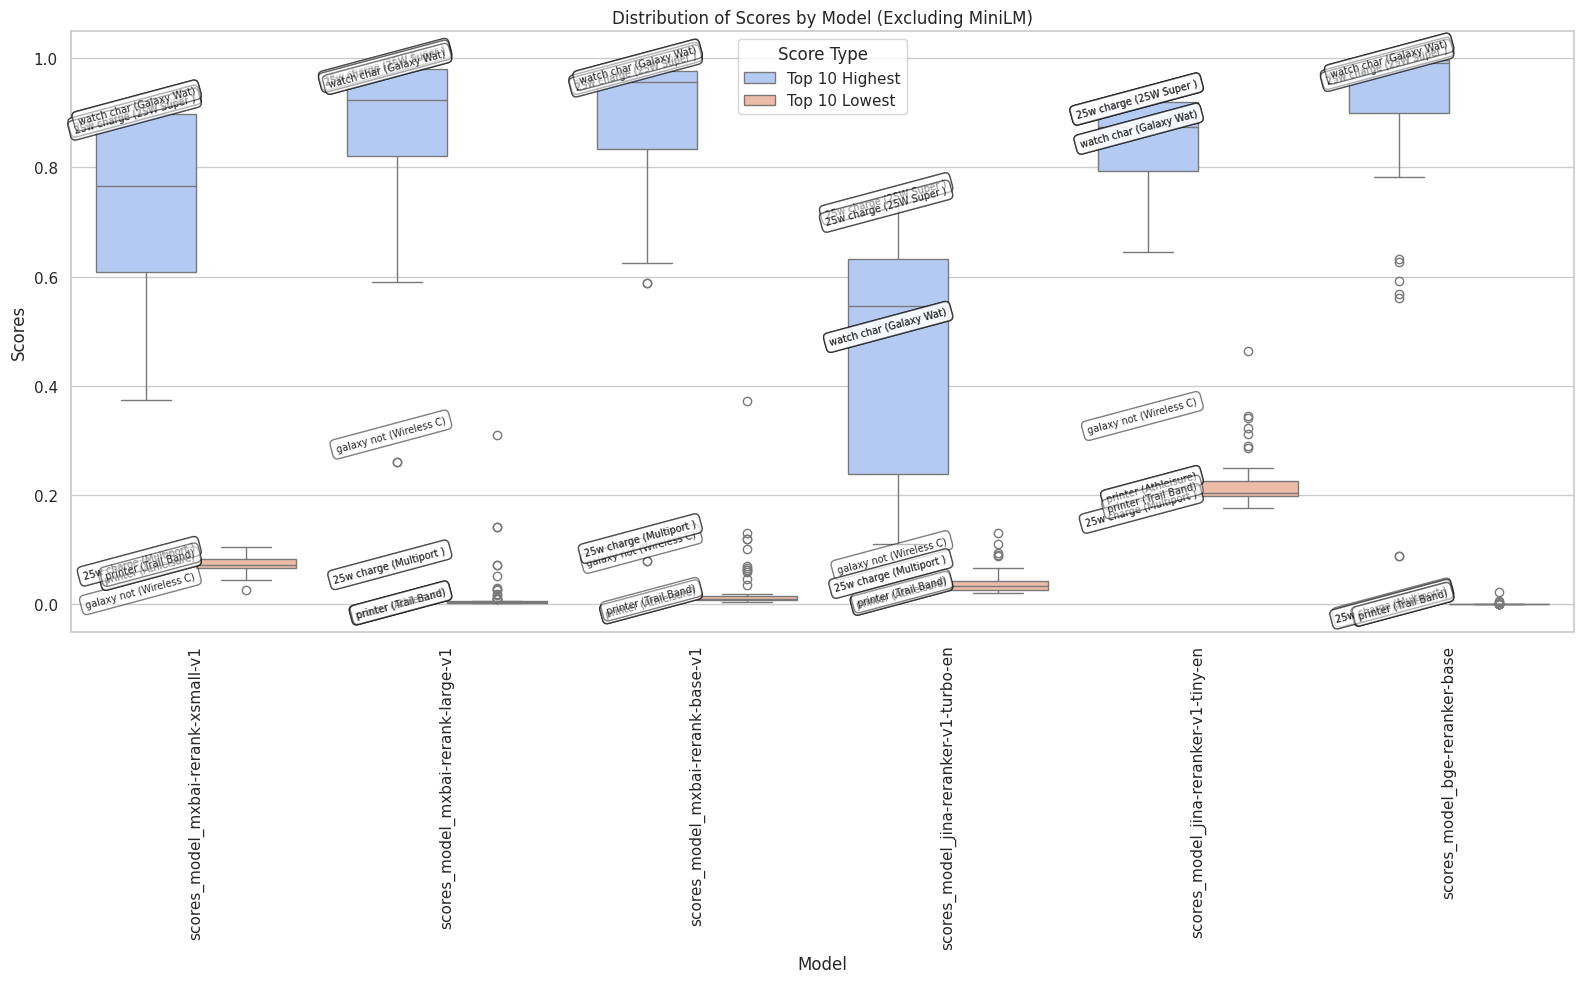

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the combined CSV file
csv_filename = "top_10_highest_and_lowest_scores_subset.csv"  # Replace with your actual CSV file name
df = pd.read_csv(csv_filename)

# Exclude the 'scores_model_MiniLM' column from the DataFrame
df_filtered = df.loc[:, ~df.columns.str.contains('scores_model_MiniLM')]

# Filter only the scores columns and melt the DataFrame
score_columns = [col for col in df_filtered.columns if col.startswith('scores_model')]
df_melted = df_filtered.melt(id_vars=['query', 'name', 'Score_Type'], value_vars=score_columns, var_name='Model', value_name='Score')

# Initialize the matplotlib figure
plt.figure(figsize=(16, 10))

# Create a box plot
sns.boxplot(data=df_melted, x='Model', y='Score', hue='Score_Type', palette='coolwarm')

# Annotate each point with its query and name, applying jitter and limiting length
for i, row in df_melted.iterrows():
    if i % 10 == 0:  # Annotate every 10th point
        query_name = f"{row['query'][:10]} ({row['name'][:10]})"  # Limit to first 10 characters of query and name
        plt.text(
            x=row['Model'],
            y=row['Score'],
            s=query_name,
            fontsize=7,  # Slightly reduce the font size
            ha='right',
            va='center',
            rotation=15,  # Add rotation to reduce overlap
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5')
        )

# Enhance the plot
plt.xticks(rotation=90)
plt.title('Distribution of Scores by Model (Excluding MiniLM)')
plt.xlabel('Model')
plt.ylabel('Scores')
plt.legend(title='Score Type')
plt.tight_layout()

# Save the box plot
plt.savefig("box_plot_scores_excluding_MiniLM_with_annotations.png")
plt.show()


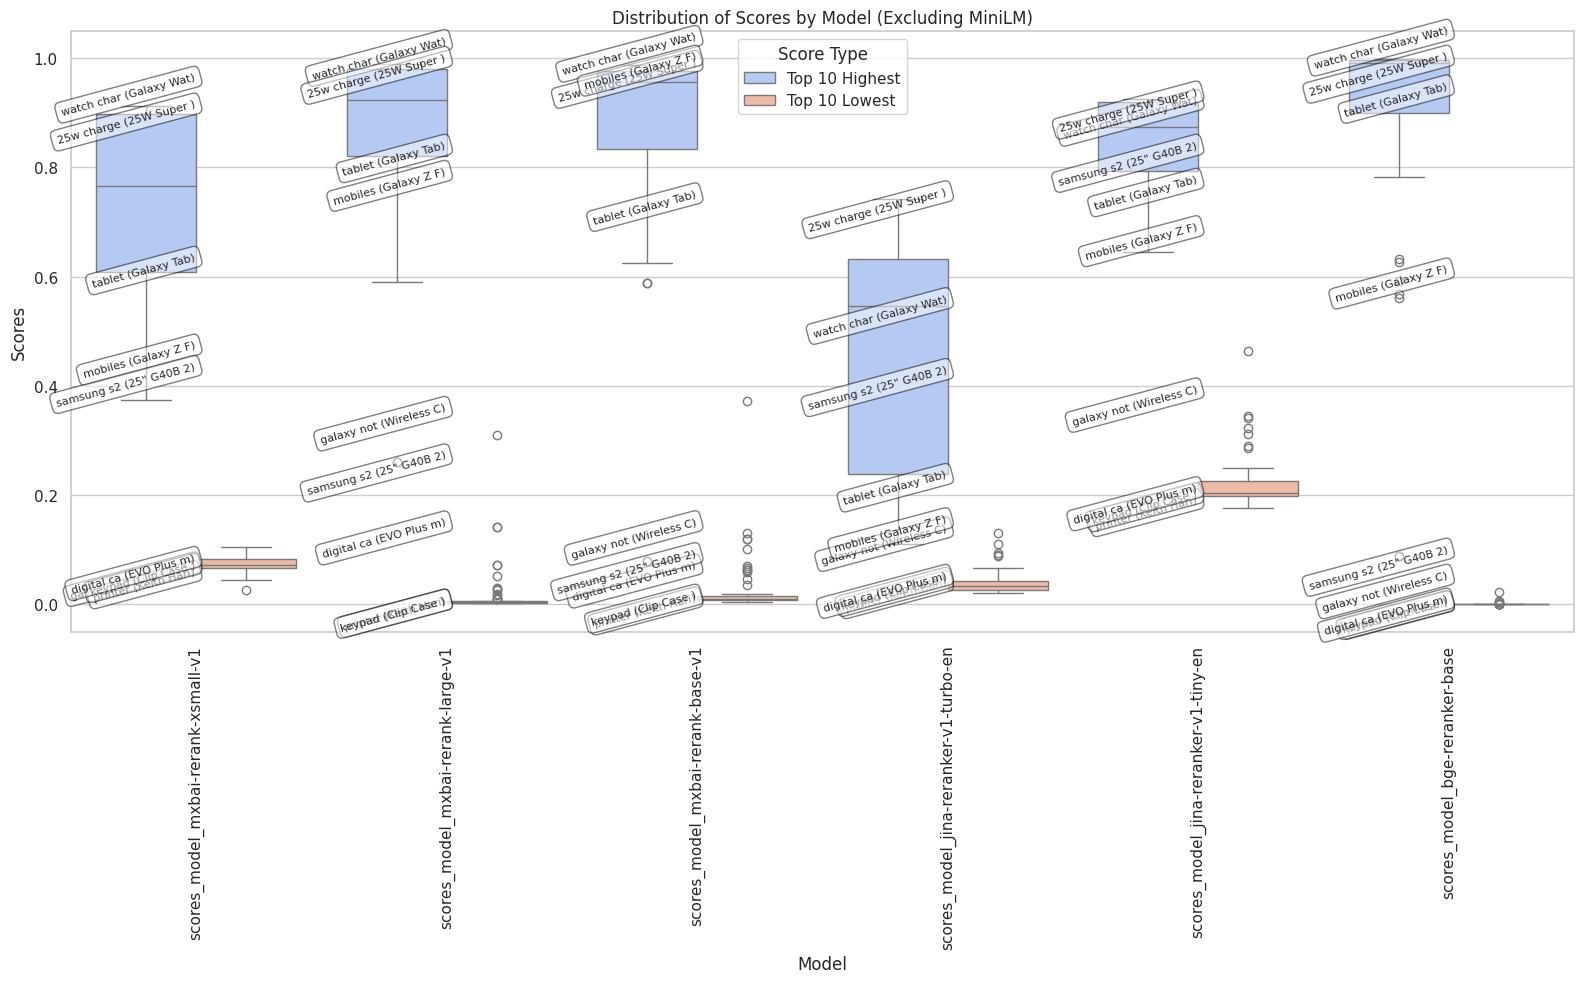

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the combined CSV file
csv_filename = "top_10_highest_and_lowest_scores_subset.csv"  # Replace with your actual CSV file name
df = pd.read_csv(csv_filename)

# Exclude the 'scores_model_MiniLM' column from the DataFrame
df_filtered = df.loc[:, ~df.columns.str.contains('scores_model_MiniLM')]

# Filter only the scores columns and melt the DataFrame
score_columns = [col for col in df_filtered.columns if col.startswith('scores_model')]
df_melted = df_filtered.melt(id_vars=['query', 'name', 'Score_Type'], value_vars=score_columns, var_name='Model', value_name='Score')

# Initialize the matplotlib figure
plt.figure(figsize=(16, 10))

# Create a box plot
sns.boxplot(data=df_melted, x='Model', y='Score', hue='Score_Type', palette='coolwarm')

# Annotate each point with its query and name, reducing overlap
annotated_queries = set()  # To keep track of annotated queries

for i, row in df_melted.iterrows():
    # Only annotate if this query hasn't been annotated for the model yet
    if (row['Model'], row['query']) not in annotated_queries:
        # Limit the annotation length to reduce overlap
        query_name = f"{row['query'][:10]} ({row['name'][:10]})"  # Shortened query and name

        # Add a slight vertical jitter to reduce overlap
        jitter_y = row['Score'] + (0.02 if i % 2 == 0 else -0.02)  # Adjusting y-axis for jitter effect

        plt.text(
            x=row['Model'],
            y=jitter_y,
            s=query_name,
            fontsize=8,
            ha='right',
            va='center',
            rotation=15,  # Add slight rotation to avoid clutter
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5')
        )
        # Mark this query as annotated for the model
        annotated_queries.add((row['Model'], row['query']))

# Enhance the plot
plt.xticks(rotation=90)
plt.title('Distribution of Scores by Model (Excluding MiniLM)')
plt.xlabel('Model')
plt.ylabel('Scores')
plt.legend(title='Score Type')
plt.tight_layout()

# Save the box plot
plt.savefig("box_plot_scores_excluding_MiniLM_with_unique_annotations.png")
plt.show()


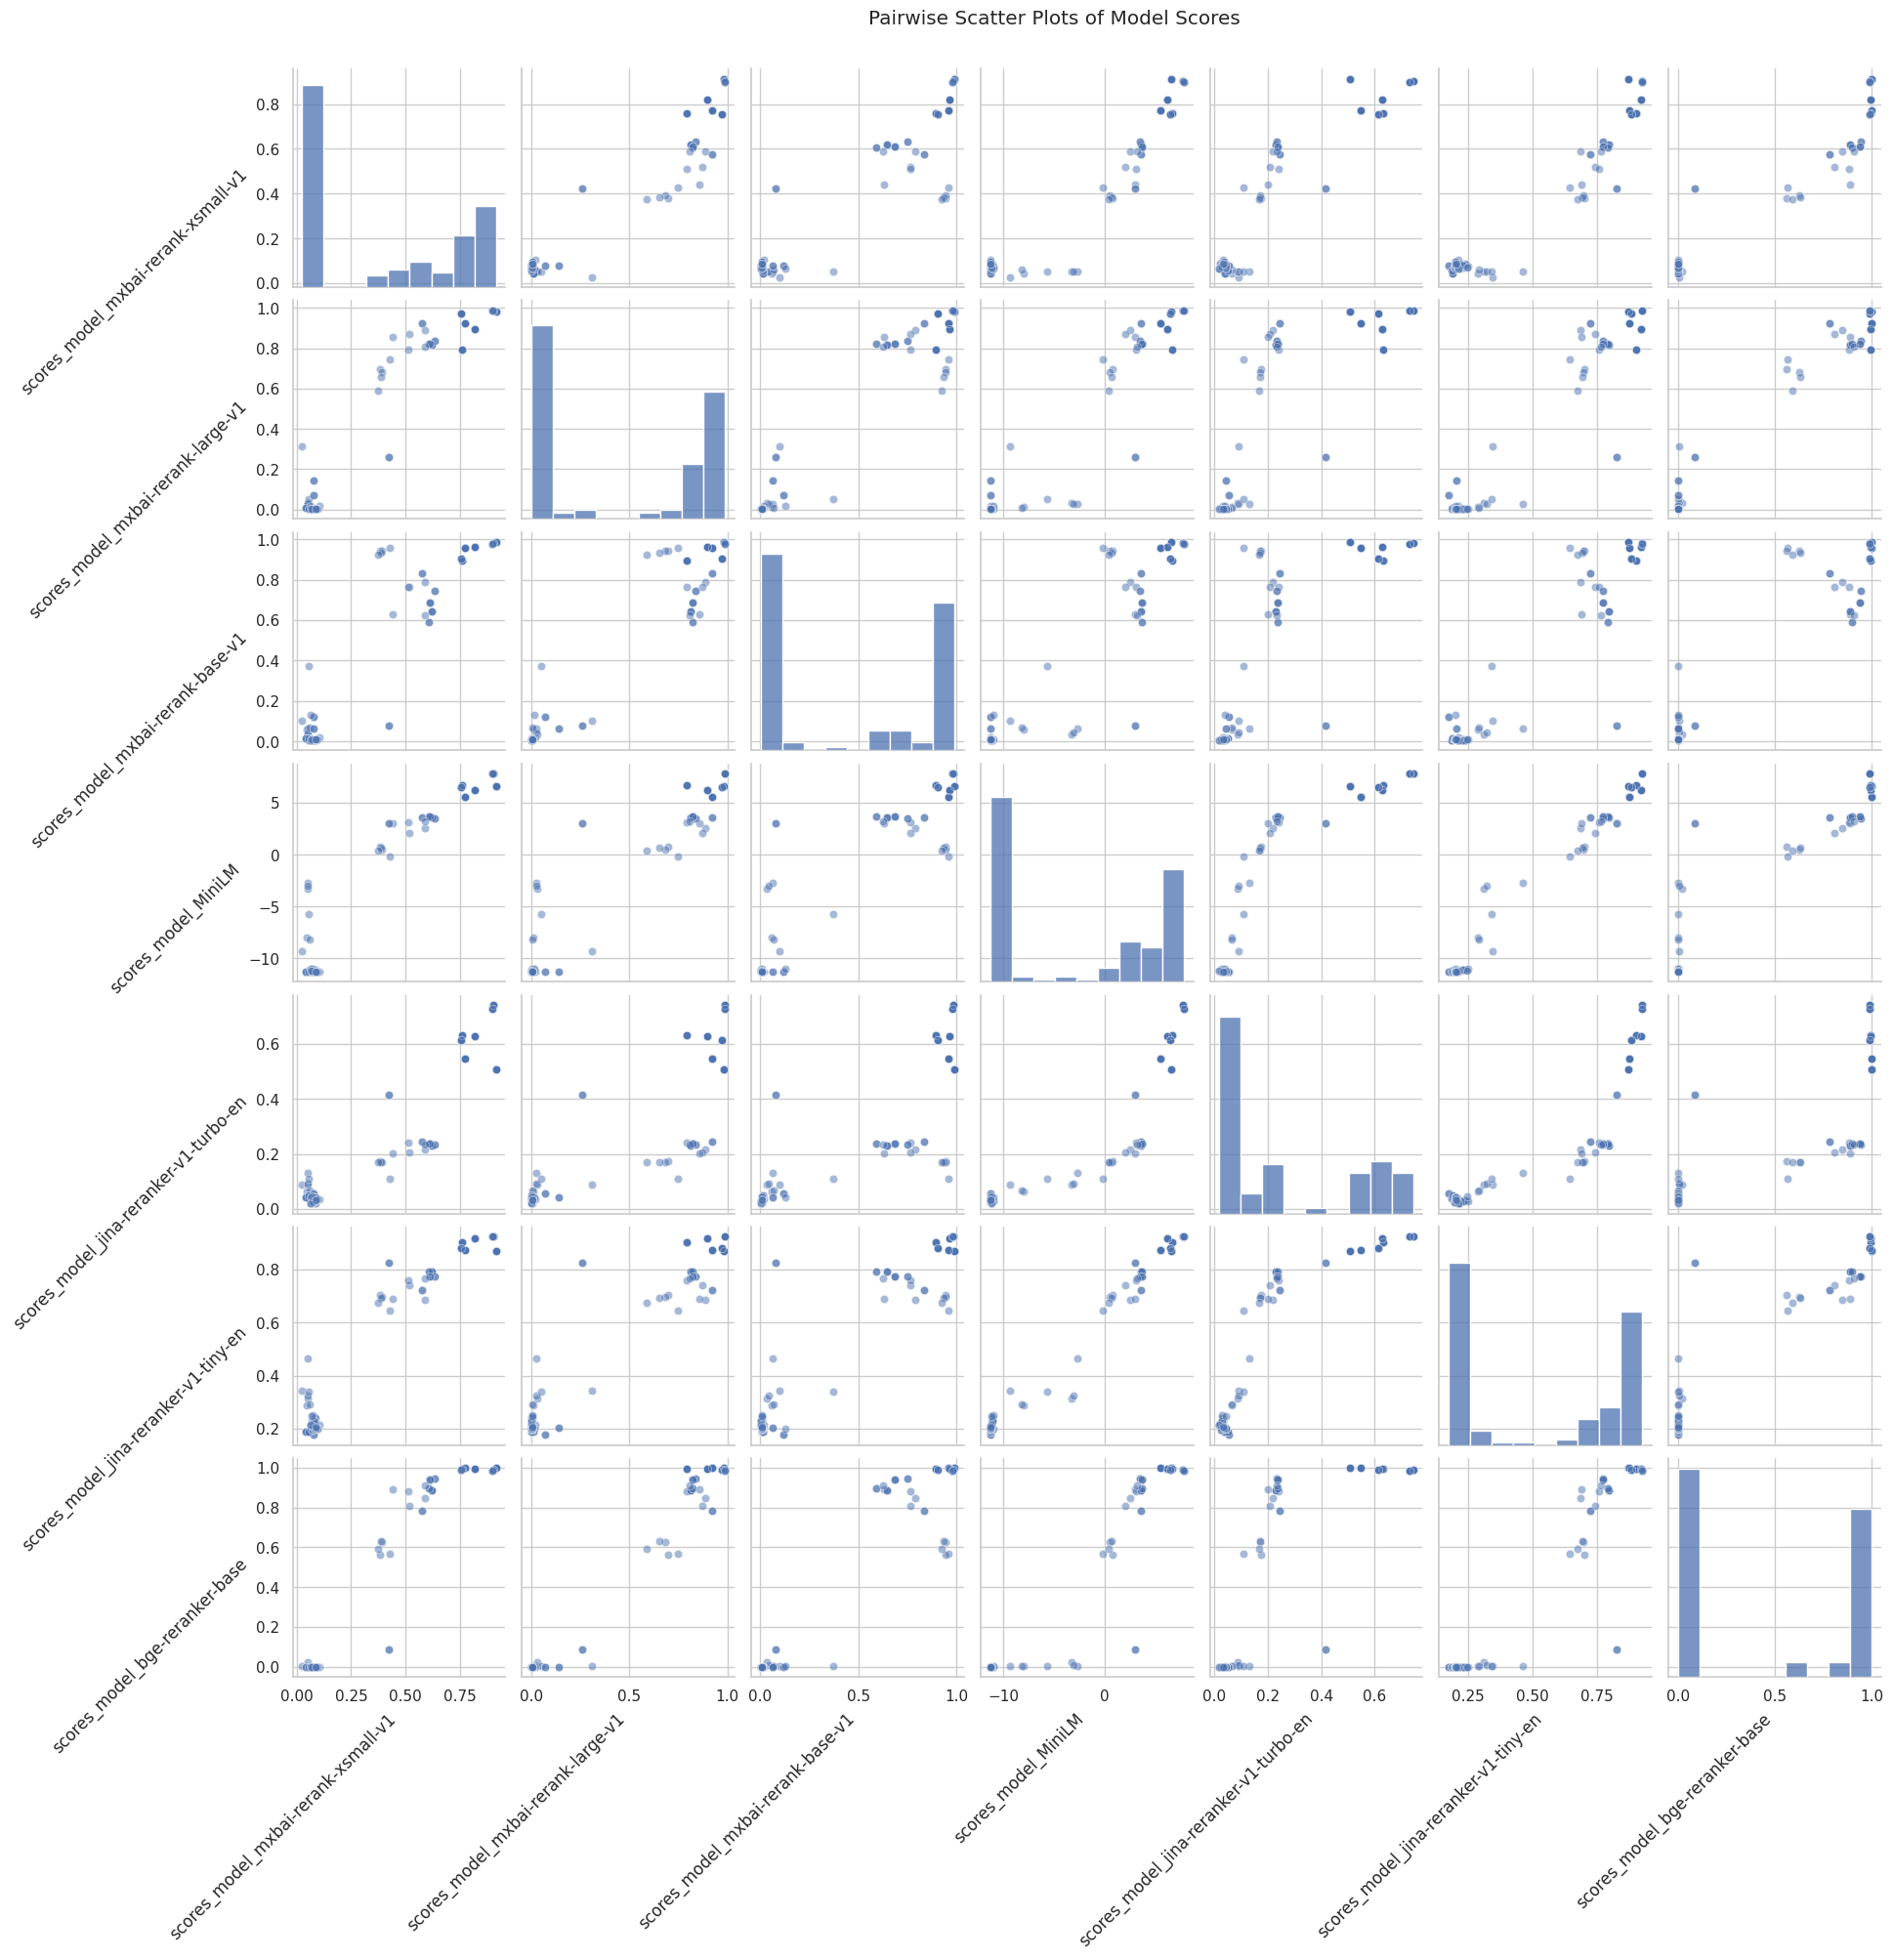

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Select columns with scores for pairwise scatter plots
score_columns = [col for col in df.columns if col.startswith('scores_model')]
df_scatter = df[score_columns]

# Create pairplot
g = sns.pairplot(df_scatter, plot_kws={'alpha':0.5})
g.fig.suptitle('Pairwise Scatter Plots of Model Scores', y=1.02)

# Rotate x and y axis labels to avoid overlap
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation = 45, ha = 'right')
    ax.set_ylabel(ax.get_ylabel(), rotation = 45, ha = 'right')

plt.savefig("pairwise_scatter_plots.png")
plt.show()


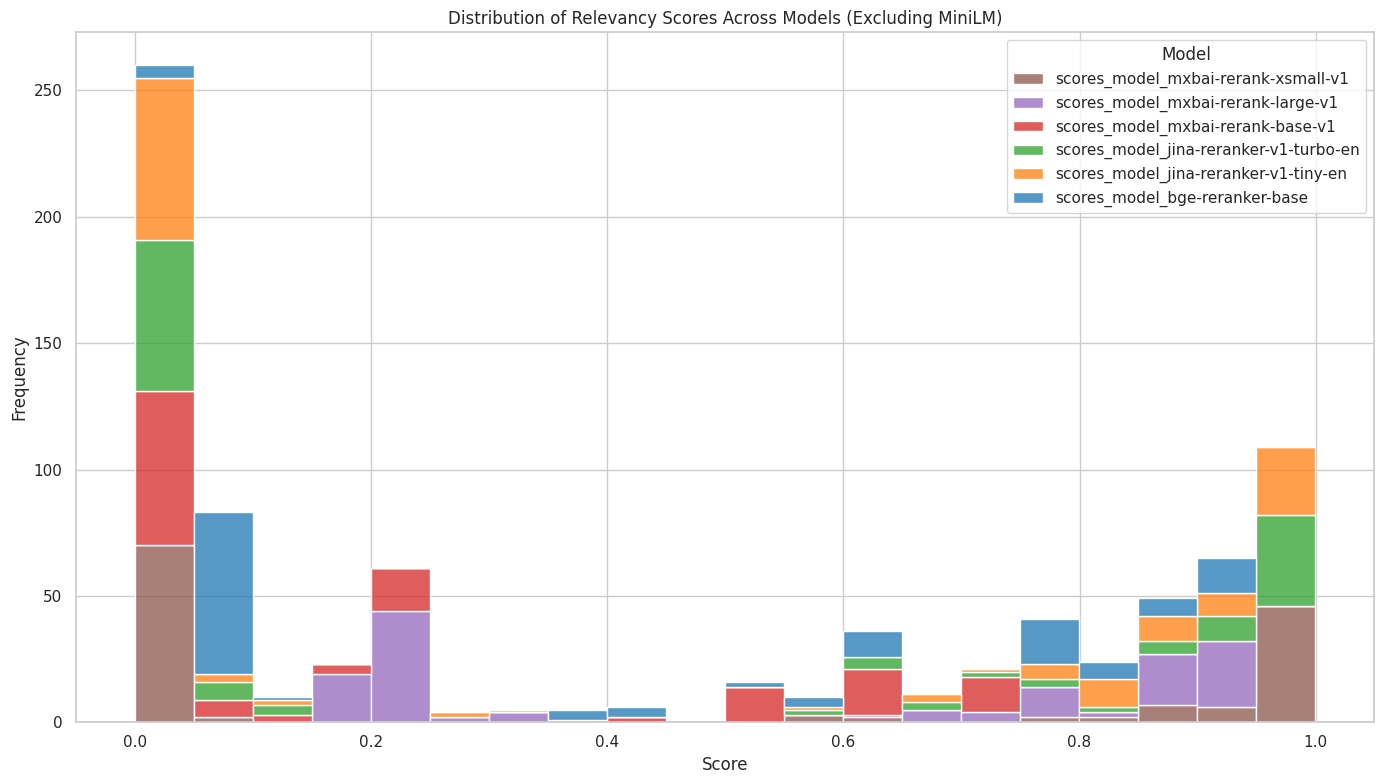

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out the MiniLM model
filtered_score_columns = [col for col in score_columns if 'MiniLM' not in col]

# Check if there are still multiple models after filtering
if len(filtered_score_columns) > 0:
    # Melt the DataFrame for distribution plots, excluding MiniLM
    df_dist = df.melt(id_vars=['query', 'name'], value_vars=filtered_score_columns, var_name='Model', value_name='Score')

    # Plot distribution
    plt.figure(figsize=(14, 8))
    sns.histplot(data=df_dist, x='Score', hue='Model', multiple='stack', palette='tab10', binwidth=0.05)

    plt.title('Distribution of Relevancy Scores Across Models (Excluding MiniLM)')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    # Manually set the legend if necessary
    if len(df_dist['Model'].unique()) > 0:
        plt.legend(title='Model', labels=df_dist['Model'].unique())
    else:
        plt.legend().remove()

    plt.tight_layout()
    plt.savefig("distribution_scores_excluding_minilm.png")
    plt.show()
else:
    print("No models available after filtering out MiniLM.")


<ipython-input-35-f3db81db0600>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




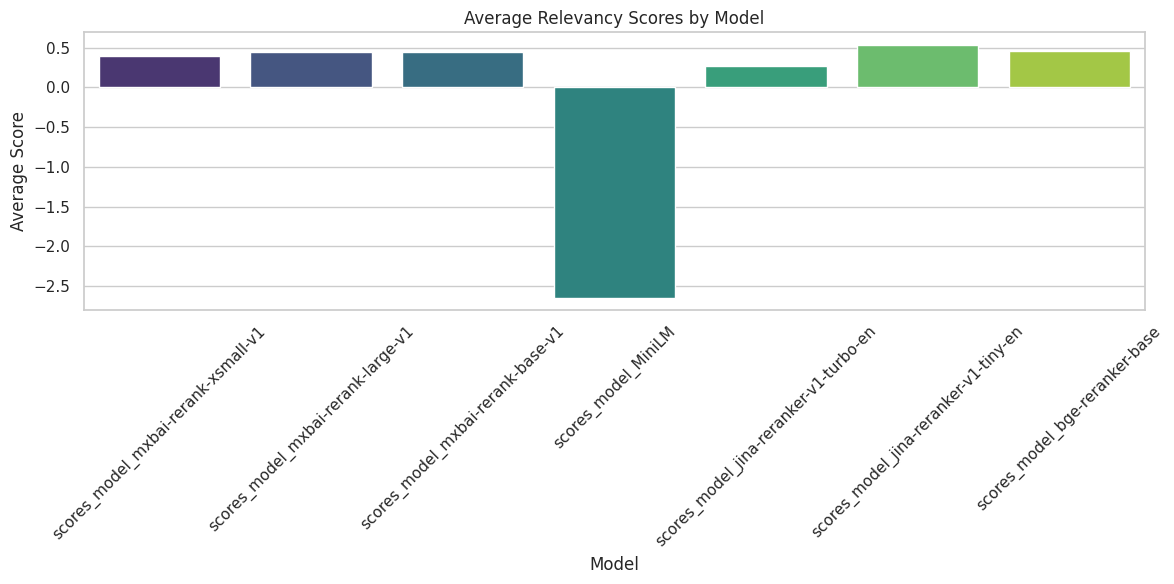

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate average scores for each model
avg_scores = df[score_columns].mean().reset_index()
avg_scores.columns = ['Model', 'Average Score']

# Plot bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Average Score', data=avg_scores, palette='viridis')
plt.title('Average Relevancy Scores by Model')
plt.xlabel('Model')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("average_scores_bar_plot.png")
plt.show()


#Flashrank with rank zephyr

In [ ]:
%%capture
!pip install flashrank[listwise]

In [ ]:
from flashrank import Ranker, RerankRequest

# # Nano (~4MB), blazing fast model & competitive performance (ranking precision).

# ranker = Ranker(max_length=128)

# or

# # Small (~34MB), slightly slower & best performance (ranking precision).
# ranker = Ranker(model_name="ms-marco-MiniLM-L-12-v2", cache_dir="/opt")

# or

# # Medium (~110MB), slower model with best zeroshot performance (ranking precision) on out of domain data.
# ranker = Ranker(model_name="rank-T5-flan", cache_dir="/opt")

# or

# # Medium (~150MB), slower model with competitive performance (ranking precision) for 100+ languages  (don't use for english)
# ranker = Ranker(model_name="ms-marco-MultiBERT-L-12", cache_dir="/opt")

# or

ranker = Ranker(model_name="rank_zephyr_7b_v1_full", max_length=1024) # adjust max_length based on your passage length

In [38]:
import pandas as pd
from flashrank import Ranker

# Load the CSV file
csv_filename = "aggregate_csv.csv"  # Replace with your actual CSV file name
df = pd.read_csv(csv_filename)

# Define all the FlashRank models
models = {
    "ms_marco_MiniLM_L_12_v2": {"model_name": "ms-marco-MiniLM-L-12-v2", "max_length": 512},
    "rank_T5_flan": {"model_name": "rank-T5-flan", "max_length": 512},
    "ms_marco_MultiBERT_L_12": {"model_name": "ms-marco-MultiBERT-L-12", "max_length": 512},
    "rank_zephyr_7b_v1_full": {"model_name": "rank_zephyr_7b_v1_full", "max_length": 1024}
}

# Function to rerank based on query and all_text pairs
def rerank_query_text_pairs(df, ranker):
    scores = []

    for index, row in df.iterrows():
        query = row['query']
        text = row['all_text']

        # Create a rerank request and get scores from the FlashRank model
        request = RerankRequest(query=query, passages=[text])
        results = ranker.rerank(request)

        # Assuming results is a list of dictionaries with "score" field
        score = results[0]['score']
        scores.append(score)

    return scores

# Iterate over each model, compute the scores, and add them as a new column in the DataFrame
for model_name, model_info in models.items():
    # Initialize the Ranker with the respective model name and max length
    ranker = Ranker(model_name=model_info["model_name"], max_length=model_info["max_length"])

    # Get the scores for the current model
    df[f'scores_{model_name}'] = rerank_query_text_pairs(df, ranker)

# Save the updated DataFrame back to the CSV file
df.to_csv(csv_filename, index=False)

print(f"Scores for all models appended to '{csv_filename}' successfully!")


ms-marco-MiniLM-L-12-v2.zip: 100%|██████████| 21.6M/21.6M [00:00<00:00, 109MiB/s]


TypeError: string indices must be integers

In [ ]:
import pandas as pd
from flashrank import Ranker, RerankRequest

# Load the CSV file
csv_filename = "aggregate_csv.csv"  # Replace with your actual CSV file name
df = pd.read_csv(csv_filename)

# Define all the FlashRank models
models = {
    "rank_zephyr_7b_v1_full": {"model_name": "rank_zephyr_7b_v1_full", "max_length": 1024},
    "ms_marco_MiniLM_L_12_v2": {"model_name": "ms-marco-MiniLM-L-12-v2", "max_length": 512},
    "rank_T5_flan": {"model_name": "rank-T5-flan", "max_length": 512},
    "ms_marco_MultiBERT_L_12": {"model_name": "ms-marco-MultiBERT-L-12", "max_length": 512}
}

# Function to rerank based on query and text passages
def rerank_query_text_pairs(df, ranker):
    scores = []

    for index, row in df.iterrows():
        query = row['query']
        text = row['all_text']

        # Create a RerankRequest object with the correct format
        rerank_request = RerankRequest(query=query, passages=[{"text": text}])

        # Get the score from the FlashRank model for the query-passage pair
        result = ranker.rerank(rerank_request)  # Adjusted to use RerankRequest object
        score = result[0]["score"]  # Assuming the result is a list of dictionaries with "score" field

        scores.append(score)

    return scores

# Iterate over each model, compute the scores, and add them as a new column in the DataFrame
for model_name, model_info in models.items():
    # Initialize the Ranker with the respective model name and max length
    ranker = Ranker(model_name=model_info["model_name"], max_length=model_info["max_length"])

    # Get the scores for the current model
    df[f'scores_{model_name}'] = rerank_query_text_pairs(df, ranker)

# Save the updated DataFrame back to the CSV file
df.to_csv(csv_filename, index=False)

print(f"Scores for all models appended to '{csv_filename}' successfully!")


In [40]:
import pandas as pd

# Sample DataFrame (replace this with your actual DataFrame)
csv_filename = "aggregate_csv.csv"  # Replace with your actual CSV file name
df = pd.read_csv(csv_filename)

# Assuming you have a `ranker` object already defined
# Replace this with the correct import/initialization for your FlashRank model
# from flashrank import FlashRankModel

ranker = Ranker(model_name="rank_zephyr_7b_v1_full", max_length=1024) # adjust max_length based on your passage length

# Placeholder for FlashRankModel
class FlashRankModel:
    def rerank(self, query, passages):
        # Implement the FlashRank scoring logic here
        # Here it just returns a fixed score for demonstration purposes
        return [{"id": idx, "score": len(query) / len(p)} for idx, p in enumerate(passages)]

# Initialize the FlashRank model
ranker = FlashRankModel()

# Function to rerank based on query and passages
def rerank_query_text_pairs(df, ranker):
    scores = []

    for index, row in df.iterrows():
        query = row['query']
        text = row['all_text']

        # Get the score from the FlashRank model for the query-text pair
        results = ranker.rerank(query, [text])

        # Assuming results is a list of dictionaries with "score" field
        score = results[0]['score']
        scores.append(score)

    return scores

# Get scores for all query-text pairs
df['scores_flashrerank_zephyr7b'] = rerank_query_text_pairs(df, ranker)



llama_model_loader: loaded meta data with 23 key-value pairs and 291 tensors from /tmp/rank_zephyr_7b_v1_full/rank_zephyr_7b_v1_full.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = hub
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.

In [45]:
import pandas as pd
from flashrank import Ranker, RerankRequest

# Load the CSV file
csv_filename = "aggregate_csv.csv"  # Replace with your actual CSV file name
df = pd.read_csv(csv_filename)

# Define all the FlashRank models
models = {
    "rank_zephyr_7b_v1_full": {"model_name": "rank_zephyr_7b_v1_full", "max_length": 1024},
    "ms_marco_MiniLM_L_12_v2": {"model_name": "ms-marco-MiniLM-L-12-v2", "max_length": 512},
    "rank_T5_flan": {"model_name": "rank-T5-flan", "max_length": 512},
    "ms_marco_MultiBERT_L_12": {"model_name": "ms-marco-MultiBERT-L-12", "max_length": 512}
}

# Function to rerank based on query and text passages
def rerank_query_text_pairs(df, ranker):
    scores = []

    for index, row in df.iterrows():
        query = row['query']
        text = row['all_text']

        # Create a RerankRequest object with the correct format
        rerank_request = RerankRequest(query=query, passages=[{"text": text}])

        # Get the score from the FlashRank model for the query-passage pair
        result = ranker.rerank(rerank_request)  # Adjusted to use RerankRequest object
        score = result[0]["score"]  # Assuming the result is a list of dictionaries with "score" field

        scores.append(score)

    return scores

# Iterate over each model, compute the scores, and add them as a new column in the DataFrame
for model_name, model_info in models.items():
    # Initialize the Ranker with the respective model name and max length
    ranker = Ranker(model_name=model_info["model_name"], max_length=model_info["max_length"])

    # Get the scores for the current model
    df[f'scores_{model_name}'] = rerank_query_text_pairs(df, ranker)

# Save the updated DataFrame back to the CSV file
df.to_csv(csv_filename, index=False)

print(f"Scores for all models appended to '{csv_filename}' successfully!")



llama_print_timings:        load time =  115359.75 ms
llama_print_timings:      sample time =      22.62 ms /    41 runs   (    0.55 ms per token,  1812.23 tokens per second)
llama_print_timings: prompt eval time =  115359.26 ms /   287 tokens (  401.95 ms per token,     2.49 tokens per second)
llama_print_timings:        eval time = 1058496.14 ms /    40 runs   (26462.40 ms per token,     0.04 tokens per second)
llama_print_timings:       total time = 1173921.87 ms /   327 tokens


KeyError: 4

In [ ]:
# Save the results to a CSV or further process them
df.to_csv('aggregate_final2.csv', index=False)

df.head()

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

In [ ]:
# @title scores_model_mxbai-rerank-xsmall-v1

from matplotlib import pyplot as plt
df['scores_model_mxbai-rerank-xsmall-v1'].plot(kind='line', figsize=(8, 4), title='scores_model_mxbai-rerank-xsmall-v1')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
df['flashrank_scores']

In [ ]:
import pandas as pd

# Assuming you have a FlashRank implementation that provides the RerankRequest function.
# Replace with actual import or implementation details
# from flashrank import FlashRank, RerankRequest

# Load the CSV file
csv_filename = "aggregate_csv_final.csv"  # Replace with your actual CSV file name
df = pd.read_csv(csv_filename)

# Placeholder for RerankRequest function and FlashRank model
# Replace this with the actual implementation
class FlashRankModel:
    def rerank(self, query, passages):
        # Implement the FlashRank scoring logic here
        return [1.0] * len(passages)  # Placeholder scores

# flashrank = FlashRankModel()

# Get scores for each query-passage pair
scores = []
for i, row in df.iterrows():
    # Create a rerank request for each query
    rerank_request = {
        'query': row['query'],
        'passages': [row['all_text']]
    }

    # Get the scores from the FlashRank model
    score = flashrank.rerank(rerank_request['query'], rerank_request['passages'])
    scores.append(score[0])  # Assuming single passage per query

# Add scores to the dataframe
df['scores_flashrerank_zephyr7b'] = scores

# Save the results to a CSV
df.to_csv('flashrank_results.csv', index=False)

print(df)


In [ ]:

# Compute the relevance scores using the cross-encoder model
scores = model.predict(pairs)

# Add the scores as a new column to the dataframe
df['scores'] = scores

# Save the updated dataframe back to the CSV file
df.to_csv(csv_filename, index=False)

print(f"Scores appended to '{csv_filename}' successfully!")

In [50]:
import pandas as pd

# Sample dataframe
# Load the CSV file
csv_filename = "aggregate_final_csv.csv"  # Replace with your actual CSV file name
df = pd.read_csv(csv_filename)



# Define a function to rank and tag scores
def rank_and_tag(row, models):
    scores = row[models]
    ranked_scores = scores.rank(ascending=False)
    tags = ['D'] * len(scores)
    tags[ranked_scores <= 3] = 'S'
    tags[(ranked_scores > 3) & (ranked_scores <= 6)] = 'A'
    tags[(ranked_scores > 6) & (ranked_scores <= 10)] = 'B'
    return pd.Series(tags, index=models)

# Apply the function to each row
tags_df = df.apply(lambda row: rank_and_tag(row, model_columns), axis=1)
tags_df.columns = [f'{col}_tag' for col in model_columns]

# Concatenate the tags DataFrame with the original DataFrame
df = pd.concat([df, tags_df], axis=1)

print(df)



KeyError: "['scores_model_mxbai-rerank-xsmall-v1_category', 'scores_model_mxbai-rerank-large-v1_category', 'scores_model_mxbai-rerank-base-v1_category', 'scores_model_MiniLM_category', 'scores_model_jina-reranker-v1-turbo-en_category', 'scores_model_jina-reranker-v1-tiny-en_category', 'scores_model_bge-reranker-base_category'] not in index"

ValueError: Unable to parse string "D" at position 1015

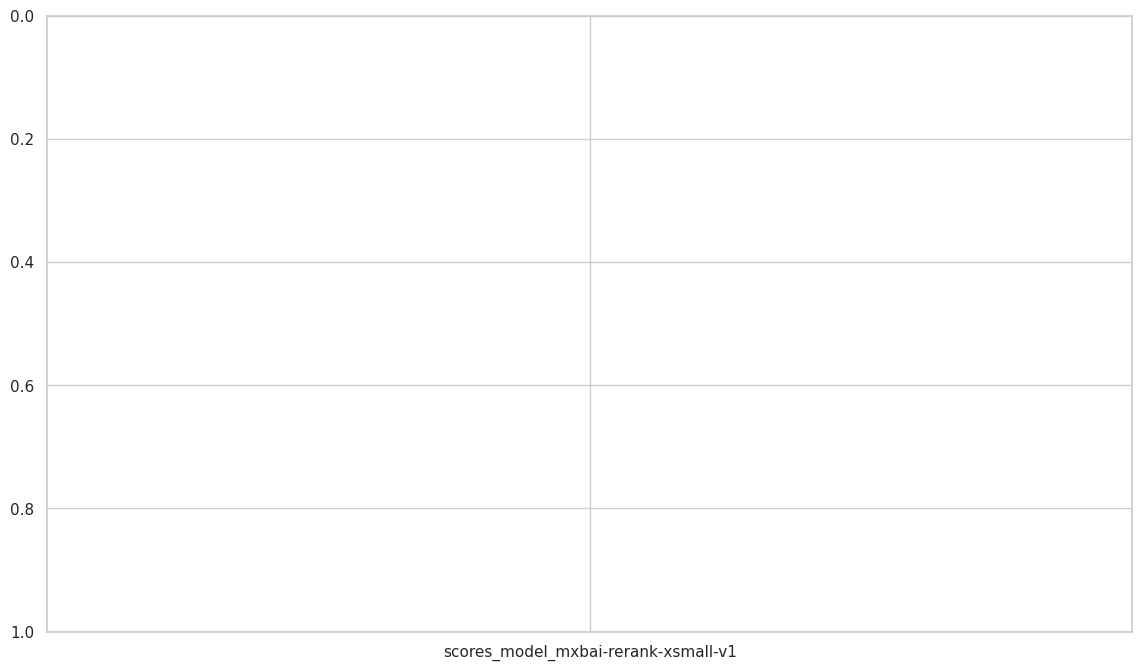

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the DataFrame (assuming it's already loaded as df)
# df = pd.read_csv('your_dataframe.csv')
# Load the CSV file
csv_filename = "aggregate_final_csv.csv"  # Replace with your actual CSV file name
df = pd.read_csv(csv_filename)
# Function to categorize scores
def categorize_scores(scores):
    sorted_scores = sorted(scores, reverse=True)
    top_1_3 = sorted_scores[:3]
    top_3_6 = sorted_scores[3:6]
    top_7_10 = sorted_scores[6:10]
    outside_top_10 = sorted_scores[10:]

    categories = []
    for score in scores:
        if score in top_1_3:
            categories.append('S')
        elif score in top_3_6:
            categories.append('A')
        elif score in top_7_10:
            categories.append('B')
        else:
            categories.append('D')

    return categories

# Apply categorization to each model's scores
for col in df.columns:
    if col.startswith('scores_model_'):
        df[f'{col}_category'] = categorize_scores(df[col])

# Box Plot
plt.figure(figsize=(14, 8))
model_columns = [col for col in df.columns if col.startswith('scores_model_')]
df_melted = df.melt(id_vars=['query'], value_vars=model_columns, var_name='Model', value_name='Score')
sns.boxplot(x='Model', y='Score', data=df_melted)
plt.xticks(rotation=45)
plt.title('Box Plot of Model Scores')
plt.show()

# Bar Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Score', data=df_melted, estimator=sum)
plt.xticks(rotation=45)
plt.title('Bar Plot of Model Scores')
plt.show()

# Heatmap
plt.figure(figsize=(14, 8))
correlation_matrix = df[model_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of Model Score Correlations')
plt.show()

# Scatter Plot (comparing two models)
plt.figure(figsize=(14, 8))
sns.scatterplot(x='scores_model_mxbai-rerank-xsmall-v1', y='scores_model_mxbai-rerank-large-v1', data=df)
plt.title('Scatter Plot of Model Scores')
plt.xlabel('Model mxbai-rerank-xsmall-v1')
plt.ylabel('Model mxbai-rerank-large-v1')
plt.show()

# Histogram
plt.figure(figsize=(14, 8))
for col in model_columns:
    sns.histplot(df[col], kde=True, label=col)
plt.legend()
plt.title('Histogram of Model Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()
